**Set random seed for reproducability**

In [1]:
import os
import numpy as np 
import tensorflow as tf
randseed = 42
np.random.seed(randseed)
tf.random.set_seed(randseed)
os.environ['PYTHONHASHSEED']=str(randseed)

**Import packages**

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
from keras import backend as K
from keras.models import Sequential, load_model 
from keras.layers import Dense, Dropout, LSTM, GRU
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import  mean_squared_error, mean_absolute_error, r2_score

**Read in dataset**

In [3]:
#Read in the Dataset
original = pd.read_csv('/kaggle/input/stocks/ABG.csv') 
original['Date'] = pd.to_datetime(original.Date) 
original.head()

Date  Open  High   Low  Close   Volume  Earnings Yield (EY)  \
0 1999-01-01  2790  2800  2750   2790        0                 10.4   
1 1999-01-04  2790  2900  2700   2850   240401                 10.2   
2 1999-01-05  2850  2900  2810   2875   339749                 10.1   
3 1999-01-06  2915  3070  2915   3050  2110485                  9.5   
4 1999-01-07  3135  3450  3135   3250  3757292                  9.0   

   Dividend Yield (DY)  P:E Ratio (P:E) Trades Trade Value  \
0                  3.3         9.615385      -           -   
1                  3.2         9.803922      -           -   
2                  3.2         9.900990      -           -   
3                  3.0        10.526316      -           -   
4                  2.8        11.111111      -           -   

   Total Return Index (TRI)  
0                     669.0  
1                     684.0  
2                     690.0  
3                     732.0  
4                     780.0

**Feature Engineering**

In [4]:
forecastHorizon = 5

#Create new dataframe
df = pd.DataFrame(data = original['Date'])  

#Target Returns (Weekly)
df['Target'] = np.log(original['Close'].shift(-forecastHorizon) / original['Close'])

#Returns from the closing price
df['Returns'] = np.log((original['Close']) / original['Close'].shift(forecastHorizon))

#Lagged Variations of returns
df['Returns1'] = np.log((original['Close']) / original['Close'].shift(1))
df['Returns2'] = np.log((original['Close']) / original['Close'].shift(2))
df['Returns3'] = np.log((original['Close']) / original['Close'].shift(3))
df['Returns4'] = np.log((original['Close']) / original['Close'].shift(4))

#Simple Moving Average (SMA) and Exponentially-weighted Moving Average (EWMA) - 5, 10, 20, 50, 200 days
numDays = 5
df['SMA (5)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (5)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

numDays = 10
df['SMA (10)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (10)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

numDays = 20
df['SMA (20)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (20)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

numDays = 50
df['SMA (50)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (50)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

numDays = 200
df['SMA (200)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (200)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

#Relative Strength Index (RSI)
numDays = 14
diff = original['Close'].diff(1)
up, down = diff.copy(), diff.copy()
up[up < 0] = 0
down[down > 0] = 0
EWMAu = up.ewm(span = numDays, min_periods = numDays).mean()
EWMAd = down.abs().ewm(span = numDays, min_periods = numDays).mean()
RS = EWMAu / EWMAd
df['RSI'] = 100.0 - (100.0 / (1.0 + RS))

#Moving Average Convergence Divergence (MACD)
df['MACD'] = df['Returns'].ewm(span = 12, min_periods = 12).mean()  - df['Returns'].ewm(span = 26, min_periods = 26).mean() 

#Commodity Channel Index (CCI) 
df['Typical Price'] = (original['High'] + original['Low'] + original['Close']) / 3
numDays = 20
df['CCI'] = (df['Typical Price'] - df['Typical Price'].rolling(numDays).mean()) / (0.015 * df['Typical Price'].rolling(numDays).std())

#Stochastic Oscillator (SO)
numDays = 14
df['SO'] = ((df['Returns'] - df['Returns'].rolling(numDays).min()) / (df['Returns'].rolling(numDays).max() - df['Returns'].rolling(numDays).min())) * 100

#Variations of Returns
df['TRI'] = np.log(original['Total Return Index (TRI)'] / original['Total Return Index (TRI)'].shift(forecastHorizon))
df['Returns Open'] = np.log(original['Open'] / original['Open'].shift(forecastHorizon))
df['Returns Low'] = np.log(original['Low'] / original['Low'].shift(forecastHorizon))
df['Returns High'] = np.log(original['High'] / original['High'].shift(forecastHorizon))
df['Returns High/Open'] = np.log(original['High'] / original['Open'].shift(forecastHorizon))
df['Returns High/Low'] = np.log(original['High'] / original['Low'].shift(forecastHorizon))
df['Returns High/Close'] = np.log(original['High'] / original['Close'].shift(forecastHorizon))
df['Returns Close/Open'] = np.log(original['Close'] / original['Open'].shift(forecastHorizon))
df['Returns Close/Low'] = np.log(original['Close'] / original['Low'].shift(forecastHorizon))
df['Returns Close/High'] = np.log(original['Close'] / original['High'].shift(forecastHorizon))
df['Returns Open/Low'] = np.log(original['Open'] / original['Low'].shift(forecastHorizon))
df['Typical Price'] = np.log(df['Typical Price'] / df['Typical Price'].shift(forecastHorizon))

#Set date to index
df.index = df['Date'] 

#Drop columns that aren't needed
df.drop(['Date'], axis=1, inplace=True)

#Drop NaNs
df = df.dropna()

#Remove 150 datapoints so no data leakage between hyperparameter optimisation window
df = df[150:]

df.head()

Target   Returns  Returns1  Returns2  Returns3  Returns4  \
Date                                                                     
2000-05-11 -0.008658 -0.004301  0.026202  0.030637  0.026202  0.008658   
2000-05-12 -0.006630 -0.013129 -0.021787  0.004415  0.008850  0.004415   
2000-05-15  0.002205  0.002210 -0.002205 -0.023992  0.002210  0.006645   
2000-05-16 -0.006659  0.004435 -0.002210 -0.004415 -0.026202  0.000000   
2000-05-17 -0.049227  0.013187  0.013187  0.010977  0.008772 -0.013015   

             SMA (5)  EWMA (5)  SMA (10)  EWMA (10)  ...  Returns Open  \
Date                                                 ...                 
2000-05-11 -0.031889 -0.020649 -0.017133  -0.015175  ...     -0.017544   
2000-05-12 -0.026003 -0.018142 -0.022702  -0.014803  ...      0.006487   
2000-05-15 -0.013541 -0.011358 -0.026737  -0.011710  ...     -0.013129   
2000-05-16 -0.005666 -0.006094 -0.026294  -0.008775  ...      0.002210   
2000-05-17  0.000480  0.000333 -0.019477  -0.004782  ...      0.004435   

            Returns Low  Returns High  Returns High/Open  Returns High/Low  \
Date                                                                         
2000-05-11     0.018019      0.000000           0.021506          0.065958   
2000-05-12     0.031322      0.008639           0.008639          0.055263   
2000-05-15     0.006719     -0.004357          -0.004357          0.028795   
2000-05-16     0.011124     -0.002195           0.006615          0.017739   
2000-05-17     0.011173     -0.004357           0.017622          0.028795   

            Returns High/Close  Returns Close/Open  Returns Close/Low  \
Date                                                                    
2000-05-11            0.008547            0.008658           0.053110   
2000-05-12            0.010811           -0.015301           0.031322   
2000-05-15            0.013187           -0.015334           0.017818   
2000-05-16            0.011050            0.000000           0.011124   
2000-05-17            0.013187            0.017622           0.028795   

            Returns Close/High  Returns Open/Low  
Date                                              
2000-05-11           -0.012848          0.026907  
2000-05-12           -0.015301          0.053110  
2000-05-15           -0.015334          0.020023  
2000-05-16           -0.008811          0.013334  
2000-05-17           -0.004357          0.015608  

[5 rows x 32 columns]

**Model Helper Functions**

In [5]:
def windowInfo(w, sequencelength, start, trainingSize, validationSize, end):
  '''
  Prints the current window information
  @params:
    w - Window Number
    sequencelength - Length of a single input sequence
    start - First datapoint index
    trainingSize - Size of the training set
    validationSize - Size of the validation set
    end - Last datapoint index
  '''
  print('Window ' + str(w + 1) + ': ')
  print('Training datapoints: ' + str(start - sequencelength) + " - " + str(start + trainingSize - 1 - sequencelength))
  print('Validation datapoints: ' + str(start + trainingSize - sequencelength) + " - " + str(start + trainingSize + validationSize - 1 - sequencelength))
  print('Testing datapoints: ' + str(start + trainingSize + validationSize - sequencelength)  + " - " + str(end - 1 - sequencelength))
  print()

def split(dataset, sequencelength, features, scaler, start, trainingSize, validationSize, testingSize, end):
  '''
  Function to split the data into a window required for Keras RNNs
  @params:
    dataset - data to be used
    sequencelength - Number of datapoints in a single input sequence
    features - Number of features in the dataset
    scaler - Initialised MinMaxScaler
    start - First datapoint index
    trainingSize - Size of the training set
    validationSize - Size of the validation set
    testingSize - Size of the testing set
    end - Last datapoint index
  @returns:
    scaler - Scaler that is fit on the training data
    x_train - Scaled Training input 
    y_train - Scaled Training output 
    y_trainUnscaled - Unscaled training output 
    x_val - Scaled validation input 
    y_val - Scaled validation output 
    y_valUnscaled - Unscaled validation output 
    x_test - Scaled testing input 
    y_test - Unscaled testing output 
  '''
  #Extracting target variables for the test and train set
  train = scaler.fit_transform(dataset[start - sequencelength : start + trainingSize, :])
  unscaled_train = dataset[start - sequencelength : start + trainingSize , 0]

  x_train = []
  y_train = []
  y_trainUnscaled = []
  for i in range(sequencelength, len(train)):
    x_train.append(train[i - sequencelength + 1 : i + 1, 1:])
    y_train.append(train[i, 0])
    y_trainUnscaled.append(unscaled_train[i])

  x_train = np.array(x_train)
  x_train = x_train.reshape((x_train.shape[0], sequencelength, features))
  y_train = np.array(y_train)
  y_trainUnscaled = np.array(y_trainUnscaled)

  #Splitting the validation set into input and output arrays
  val = scaler.transform(dataset[start + trainingSize - sequencelength : end - testingSize, :])
  unscaled_val = dataset[start + trainingSize - sequencelength : end - testingSize , 0]

  x_val = []
  y_val = []
  y_valUnscaled = []
  for i in range(sequencelength, len(val)):
    x_val.append(val[i - sequencelength + 1 : i + 1, 1:])
    y_val.append(val[i, 0])
    y_valUnscaled.append(unscaled_val[i])

  x_val = np.array(x_val)
  x_val = x_val.reshape((x_val.shape[0], sequencelength, features))
  y_val = np.array(y_val)
  y_valUnscaled = np.array(y_valUnscaled)

  #Splitting the testing set into input an array
  test = scaler.transform(dataset[start + trainingSize + validationSize - sequencelength : end, :])
  unscaled_test = dataset[start + trainingSize + validationSize - sequencelength : end, 0]

  x_test = []
  y_test = []
  for i in range(sequencelength, len(test)):
    x_test.append(test[i - sequencelength + 1 : i + 1, 1:])
    y_test.append(unscaled_test[i])

  x_test = np.array(x_test) 
  x_test = x_test.reshape((x_test.shape[0], sequencelength, features))
  y_test = np.array(y_test)

  return scaler, x_train, y_train, y_trainUnscaled, x_val, y_val, y_valUnscaled, x_test, y_test

def makePredictions(model, predictions, x_train, x_val, x_test):
  '''
  Performs inference using the model
  @params:
    model - LSTM or GRU (Keras Framework)
    predictions - Array that stores predictions across windows
    x_train - Training input data
    x_val - Validation input data
    x_test - Testing input data
  @returns:
    predictions - Updated prediction array
    trainingPredictions - Training set predictions
    valPredictions - Validation set predictions
    testingPredictions - Testing set predictions
  '''
  #Forecasts on training set
  temp = x_train
  trainingPredictions = model.predict(x_train)
  temp = temp.reshape((temp.shape[0], sequencelength * features))
  invPred = np.concatenate((trainingPredictions, temp[:,:features]), axis=1)
  trainingPredictions = scaler.inverse_transform(invPred)[:,0]
  trainingPredictions = trainingPredictions.reshape((trainingPredictions.shape[0], 1))

  #Forecasts on validation set
  temp = x_val
  valPredictions = model.predict(x_val)
  temp = temp.reshape((temp.shape[0], sequencelength * features))
  invPred = np.concatenate((valPredictions, temp[:,:features]), axis=1)
  valPredictions = scaler.inverse_transform(invPred)[:,0]
  valPredictions = valPredictions.reshape((valPredictions.shape[0], 1))

  #Forecasts on test set
  temp = x_test
  testingPredictions = model.predict(x_test)
  temp = temp.reshape((temp.shape[0], sequencelength * features))
  invPred = np.concatenate((testingPredictions, temp[:,:features]), axis=1)
  testingPredictions = scaler.inverse_transform(invPred)[:,0]
  testingPredictions = testingPredictions.reshape((testingPredictions.shape[0], 1))

  #Keep track of overall predictions
  predictions[start - sequencelength: start - sequencelength + testingSize, :] = testingPredictions

  return predictions, trainingPredictions, valPredictions, testingPredictions

def performance(actual, predictions, sett):
  '''
  Calculate the performance metrics for a specific window
  @params:
    actual - True values
    predictions - predicted values
    sett - Training/Validation/Testing set
  '''
  mse = mean_squared_error(actual, predictions)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(actual, predictions)
  r2 = r2_score(actual, predictions)

  print("Results on " + sett + " set: ")
  print('MSE = ' + str(mse))
  print('RMSE = ' + str(rmse))
  print('MAE = ' + str(mae))
  print('R-Squared = ' + str(r2))
  print()

  return 

def evaluate_model(y_trainUnscaled, y_valUnscaled, y_test, trainingPredictions, valPredictions, testingPredictions):
  '''
  Evaluates the performance of the model
  @params:
    y_trainUnscaled - True Training set values 
    y_valUnscaled - True validation set values
    y_test - True Testing set values
    trainingPredictions - Predicted Training set values 
    valPredictions - Predicted validation set values
    testingPredictions - Predicted Testing set values
  '''
  performance(y_trainUnscaled, trainingPredictions, 'Training')
  performance (y_valUnscaled, valPredictions, 'Validation')
  performance(y_test, testingPredictions, 'Testing')

  return 

**LSTM model**

In [6]:
def create_lstm():
  '''
  Function to create an LSTM using the Keras Framework
  @returns
    model - Compiled LSTM
  '''
  #hyperparameters
  learningRate = 0.001
  dropout = 0.006116997095515014
  units = 256
  
  #Construct LSTM
  model = Sequential()
  model.add(LSTM(units=units, return_sequences=True, input_shape=(sequencelength, features)))
  model.add(LSTM(units=units, dropout=dropout))
  model.add(Dense(1))

  #LSTM compile
  ao = Adam(lr=learningRate, amsgrad=True)
  model.compile(loss='mae', optimizer=ao, metrics=['mse','mae', 'mape', 'msle'])

  return model

def train_lstm(model, x_train, y_train, x_val, y_val):
  '''
  Function to train the LSTM
  @params:
    model - Keras LSTM model
    x_train - Training Input
    y_train - Training Output
    x_val - Validation Input
    y_val - Validation Output
  @returns:
    history - Model history
    model - Best model according to early stopping
  '''
  batchSize = 44
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=20)
  mc = ModelCheckpoint('./LSTM.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
  history = model.fit(x_train, y_train, epochs=150, batch_size=batchSize, verbose=0, validation_data = (x_val, y_val), callbacks=[es, mc])
  model = load_model('./LSTM.h5')
  return history, model

**LSTM Forecasting Implementation**

Window 1: 
Training datapoints: 0 - 999
Validation datapoints: 1000 - 1099
Testing datapoints: 1100 - 1249

Results on Training set: 
MSE = 0.0018123047377452749
RMSE = 0.04257117261416785
MAE = 0.029664151573875103
R-Squared = 0.15021104590624135

Results on Validation set: 
MSE = 0.0005933110054014391
RMSE = 0.024357976217277148
MAE = 0.018834050068445133
R-Squared = 0.048925446937543415

Results on Testing set: 
MSE = 0.0009619000178668931
RMSE = 0.031014513019986194
MAE = 0.024894933715106683
R-Squared = -0.2637053443490802



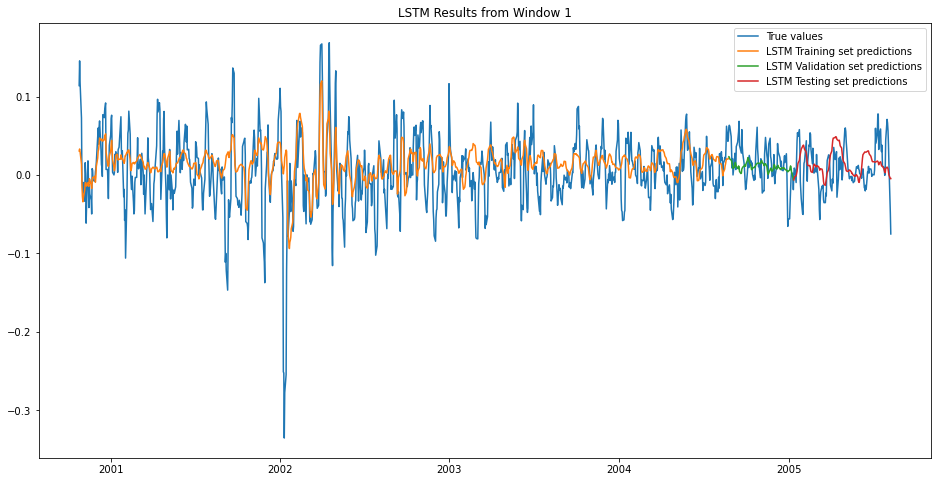

Window 2: 
Training datapoints: 150 - 1149
Validation datapoints: 1150 - 1249
Testing datapoints: 1250 - 1399

Results on Training set: 
MSE = 0.0018521316209488714
RMSE = 0.043036398791591185
MAE = 0.03006767275323272
R-Squared = 0.06080960714246442

Results on Validation set: 
MSE = 0.0007571079544461036
RMSE = 0.027515594749997745
MAE = 0.019063111269623973
R-Squared = -0.14438526964869824

Results on Testing set: 
MSE = 0.0012666118551503504
RMSE = 0.03558949079644651
MAE = 0.02951475432957778
R-Squared = 0.03142390819995022



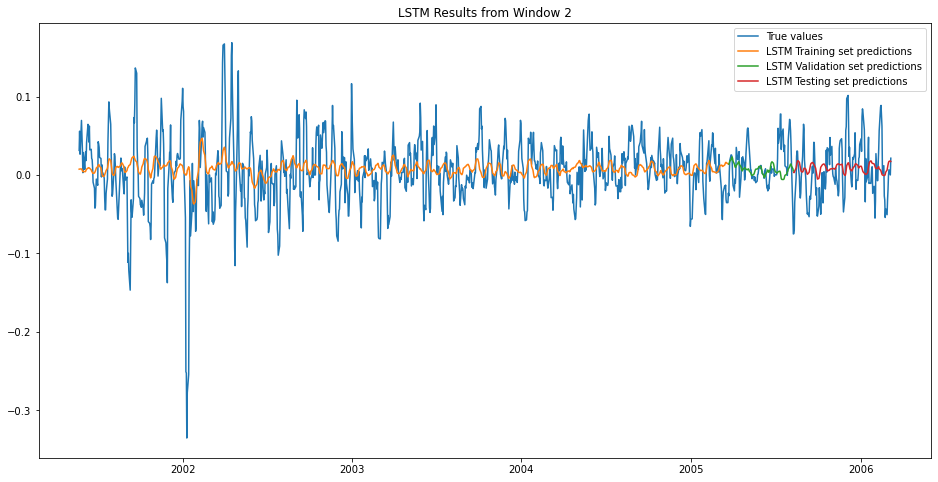

Window 3: 
Training datapoints: 300 - 1299
Validation datapoints: 1300 - 1399
Testing datapoints: 1400 - 1549

Results on Training set: 
MSE = 0.0015892592603867005
RMSE = 0.039865514676054294
MAE = 0.02815780322327169
R-Squared = 0.08903079355830368

Results on Validation set: 
MSE = 0.001144353759854007
RMSE = 0.03382829821102455
MAE = 0.027747324838830054
R-Squared = 0.06312472847748063

Results on Testing set: 
MSE = 0.002187018061091753
RMSE = 0.0467655649072237
MAE = 0.03396046472266601
R-Squared = 0.03590196038089166



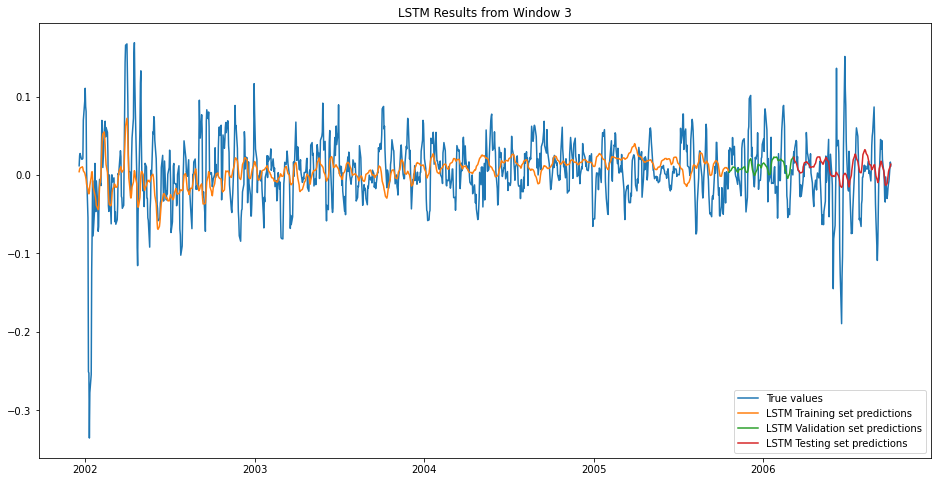

Window 4: 
Training datapoints: 450 - 1449
Validation datapoints: 1450 - 1549
Testing datapoints: 1550 - 1699

Results on Training set: 
MSE = 0.0008975619793919701
RMSE = 0.0299593387676025
MAE = 0.02322267068837707
R-Squared = 0.14499892460571207

Results on Validation set: 
MSE = 0.002906002741258522
RMSE = 0.053907353313425825
MAE = 0.0373871436827998
R-Squared = 0.030285615873801186

Results on Testing set: 
MSE = 0.001298463834056057
RMSE = 0.036034203668959534
MAE = 0.029885631756546984
R-Squared = -0.03334819071813189



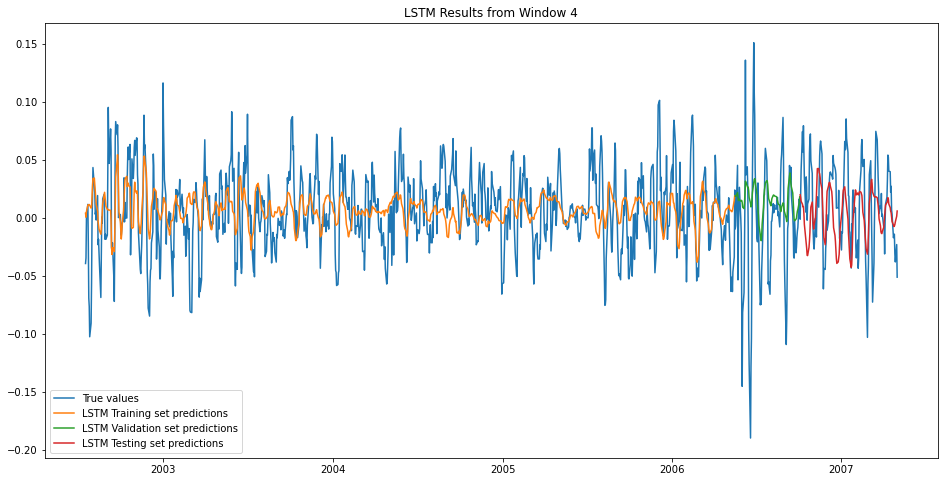

Window 5: 
Training datapoints: 600 - 1599
Validation datapoints: 1600 - 1699
Testing datapoints: 1700 - 1849

Results on Training set: 
MSE = 0.000578077668225512
RMSE = 0.024043245792228468
MAE = 0.018201912748097564
R-Squared = 0.502757852859888

Results on Validation set: 
MSE = 0.0011526520332045655
RMSE = 0.03395072949443893
MAE = 0.02774155466955736
R-Squared = 0.10068441188589994

Results on Testing set: 
MSE = 0.0019478378026822737
RMSE = 0.04413431547766742
MAE = 0.0352791653627912
R-Squared = -0.2739290067567106



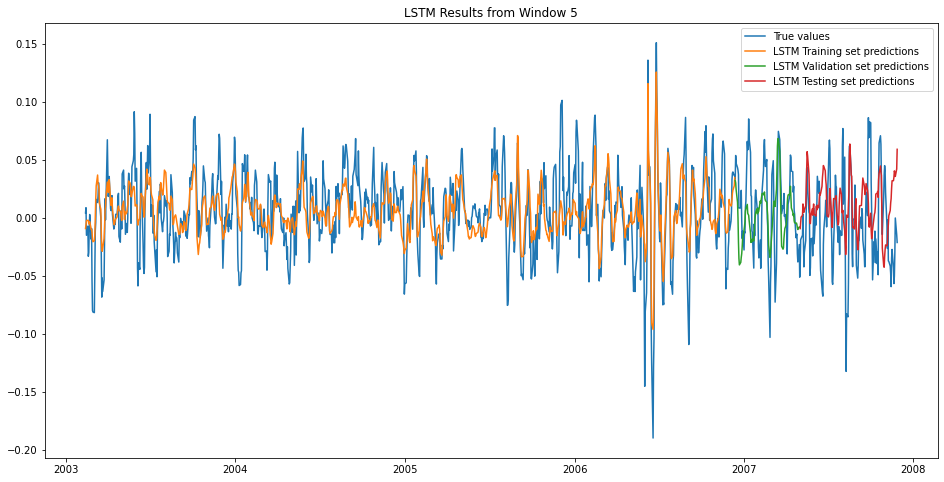

Window 6: 
Training datapoints: 750 - 1749
Validation datapoints: 1750 - 1849
Testing datapoints: 1850 - 1999

Results on Training set: 
MSE = 0.0009461580487620773
RMSE = 0.03075968219540113
MAE = 0.023298870525085783
R-Squared = 0.20573462573941437

Results on Validation set: 
MSE = 0.0019228953525672384
RMSE = 0.04385083069415263
MAE = 0.03536671799353534
R-Squared = -0.09632330456737614

Results on Testing set: 
MSE = 0.004415841010005392
RMSE = 0.0664517946334438
MAE = 0.056277059649818474
R-Squared = -1.5150699321798546



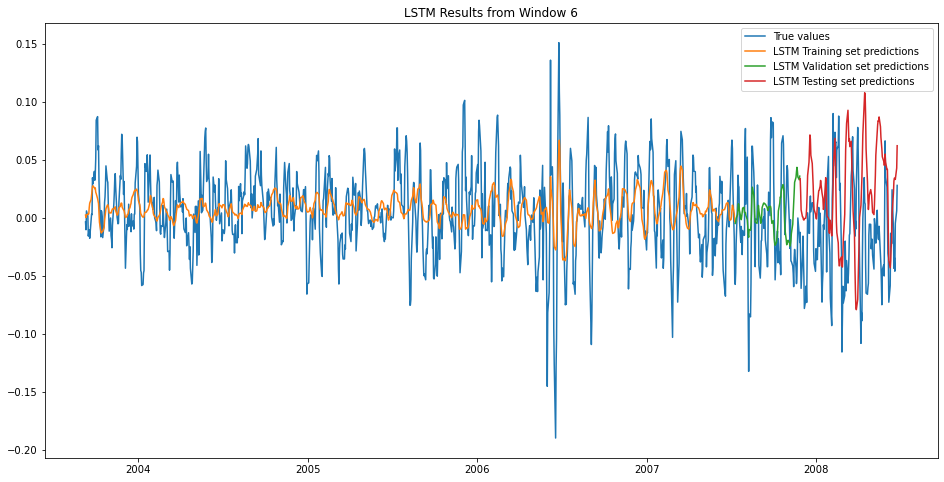

Window 7: 
Training datapoints: 900 - 1899
Validation datapoints: 1900 - 1999
Testing datapoints: 2000 - 2149

Results on Training set: 
MSE = 0.00124276082680696
RMSE = 0.03525281303395461
MAE = 0.027064489264446507
R-Squared = 0.07479543735120675

Results on Validation set: 
MSE = 0.0026250328237623407
RMSE = 0.05123507415591726
MAE = 0.04262568698602075
R-Squared = -0.2707542854957381

Results on Testing set: 
MSE = 0.0045743791796501445
RMSE = 0.06763415690056426
MAE = 0.053426229379584245
R-Squared = -0.00042768098401246846



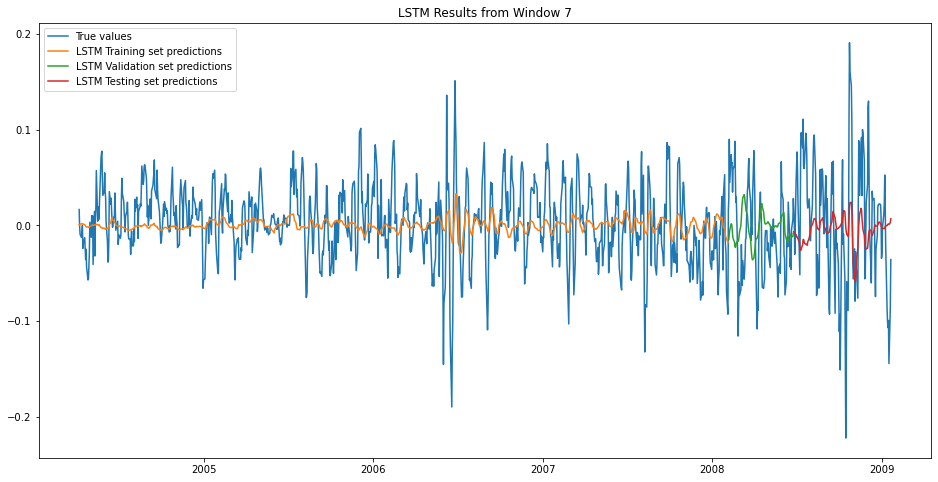

Window 8: 
Training datapoints: 1050 - 2049
Validation datapoints: 2050 - 2149
Testing datapoints: 2150 - 2299

Results on Training set: 
MSE = 0.0013080899651490418
RMSE = 0.036167526389691645
MAE = 0.027391000581055154
R-Squared = 0.18005101534438972

Results on Validation set: 
MSE = 0.0037166079076954694
RMSE = 0.06096398861373384
MAE = 0.04841989922417569
R-Squared = 0.29292217125102504

Results on Testing set: 
MSE = 0.003043087416242511
RMSE = 0.055164185992748145
MAE = 0.04171180876816681
R-Squared = -0.0683838242822723



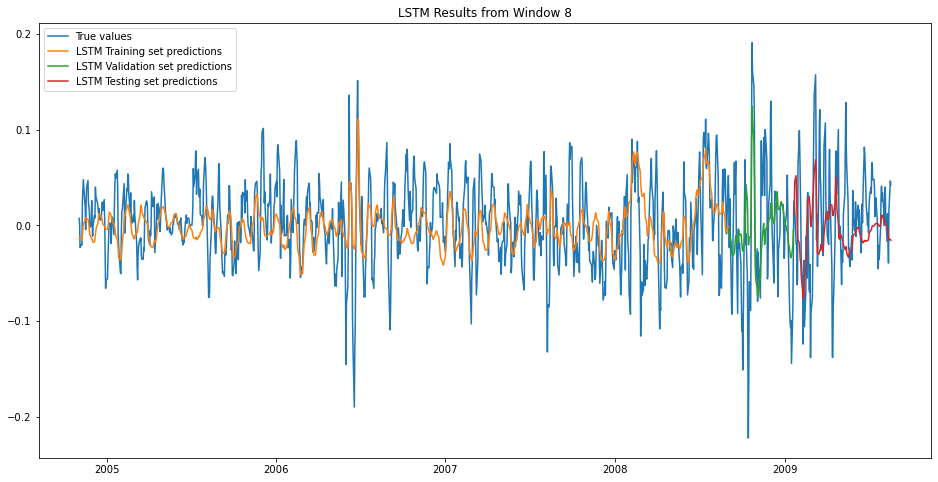

Window 9: 
Training datapoints: 1200 - 2199
Validation datapoints: 2200 - 2299
Testing datapoints: 2300 - 2449

Results on Training set: 
MSE = 0.0014773703004071607
RMSE = 0.038436575034817566
MAE = 0.02890661914633177
R-Squared = 0.3487087831976361

Results on Validation set: 
MSE = 0.0017289850787757257
RMSE = 0.041581066349670806
MAE = 0.02992878717970943
R-Squared = 0.0694315862092888

Results on Testing set: 
MSE = 0.0009975737882586269
RMSE = 0.03158439152902311
MAE = 0.024850817110040842
R-Squared = -0.14555753600301125



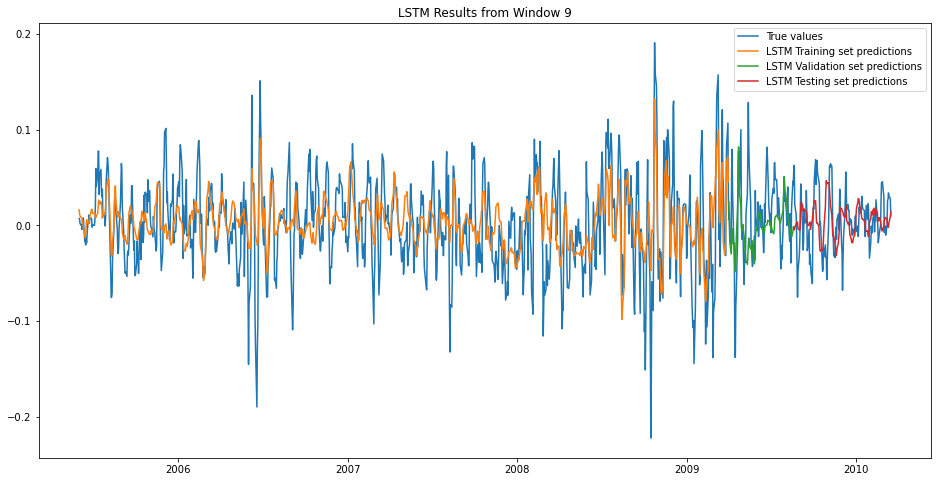

Window 10: 
Training datapoints: 1350 - 2349
Validation datapoints: 2350 - 2449
Testing datapoints: 2450 - 2599

Results on Training set: 
MSE = 0.0013355472057677042
RMSE = 0.0365451392905774
MAE = 0.027778610573089633
R-Squared = 0.43383360830968876

Results on Validation set: 
MSE = 0.000444761993312281
RMSE = 0.02108938105569438
MAE = 0.01577323326877693
R-Squared = 0.2413609796219367

Results on Testing set: 
MSE = 0.0016282461023006873
RMSE = 0.04035153159795409
MAE = 0.03207715114181143
R-Squared = -0.6809339456378196



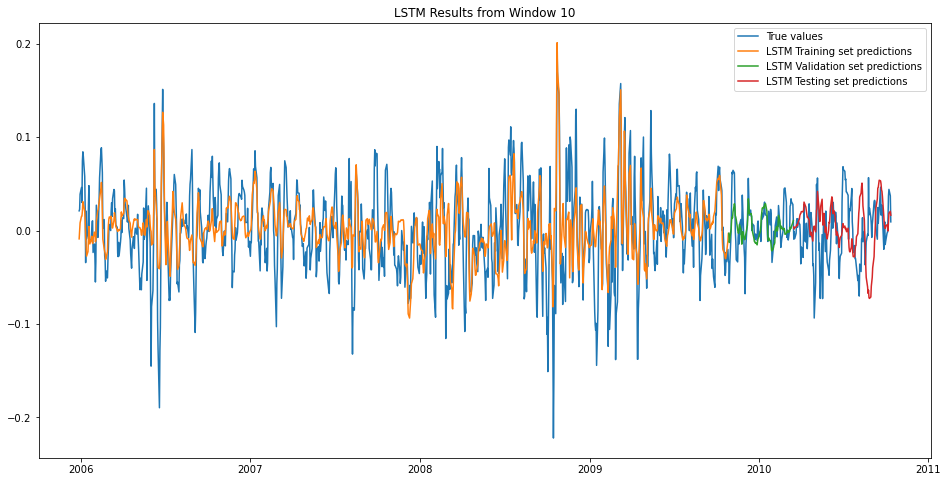

Window 11: 
Training datapoints: 1500 - 2499
Validation datapoints: 2500 - 2599
Testing datapoints: 2600 - 2749

Results on Training set: 
MSE = 0.0011502193448932275
RMSE = 0.033914883825442
MAE = 0.025254378199358215
R-Squared = 0.45659101735502994

Results on Validation set: 
MSE = 0.0012657461766853867
RMSE = 0.0355773267220204
MAE = 0.02760798241013491
R-Squared = -0.33231135012492974

Results on Testing set: 
MSE = 0.0007741726410568415
RMSE = 0.027823958040811544
MAE = 0.02238259711036496
R-Squared = -0.6348920915223386



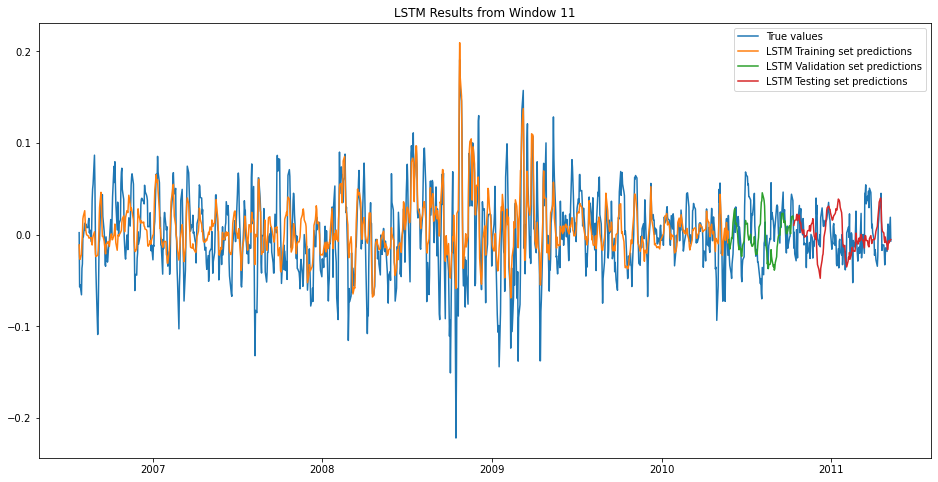

Window 12: 
Training datapoints: 1650 - 2649
Validation datapoints: 2650 - 2749
Testing datapoints: 2750 - 2899

Results on Training set: 
MSE = 0.0014550933351999485
RMSE = 0.03814568566954785
MAE = 0.02800344432272212
R-Squared = 0.27851321687986774

Results on Validation set: 
MSE = 0.00043770829609891766
RMSE = 0.020921479299966284
MAE = 0.017060575154157546
R-Squared = 0.2106600707911256

Results on Testing set: 
MSE = 0.0008082354019644108
RMSE = 0.028429481211664956
MAE = 0.022650809704119087
R-Squared = 0.030799054372574797



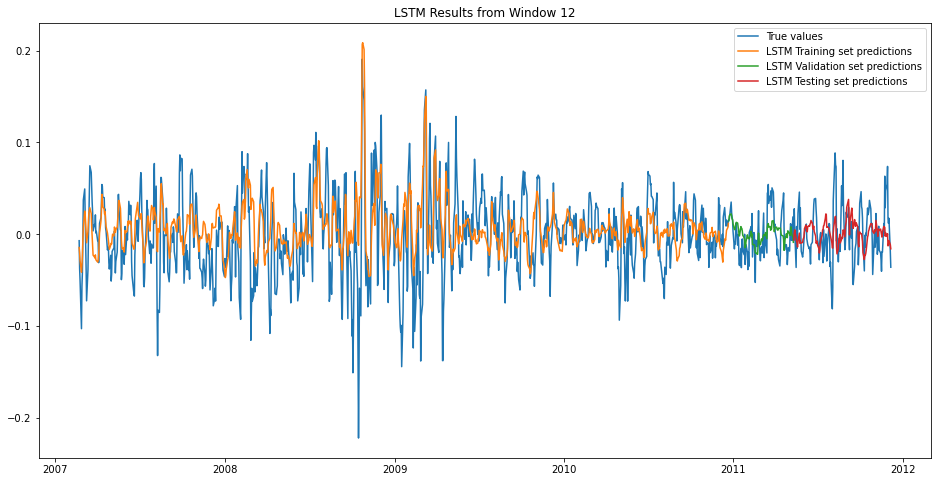

Window 13: 
Training datapoints: 1800 - 2799
Validation datapoints: 2800 - 2899
Testing datapoints: 2900 - 3049

Results on Training set: 
MSE = 0.0003656785854884115
RMSE = 0.01912272432182223
MAE = 0.014454696420517802
R-Squared = 0.8051671343410656

Results on Validation set: 
MSE = 0.0007169248735671743
RMSE = 0.026775452817219998
MAE = 0.020873858831082077
R-Squared = 0.32188190184212184

Results on Testing set: 
MSE = 0.0019974995006533545
RMSE = 0.044693394373814956
MAE = 0.0341041170132455
R-Squared = -1.4012801975508422



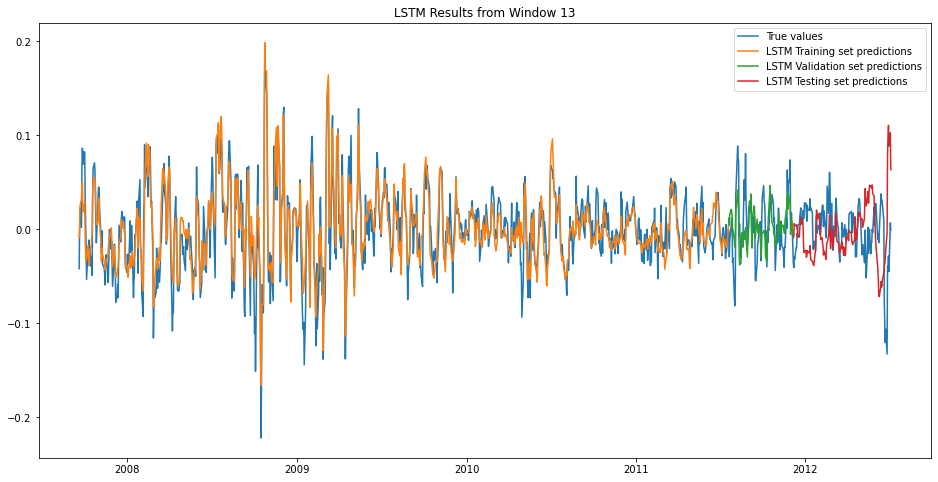

Window 14: 
Training datapoints: 1950 - 2949
Validation datapoints: 2950 - 3049
Testing datapoints: 3050 - 3199

Results on Training set: 
MSE = 0.0014352622670312806
RMSE = 0.037884855378254784
MAE = 0.02756748865919203
R-Squared = 0.14703809568806236

Results on Validation set: 
MSE = 0.0010611834165493075
RMSE = 0.032575810297662704
MAE = 0.02273748317784644
R-Squared = -0.004878664585344916

Results on Testing set: 
MSE = 0.0009664453464730179
RMSE = 0.03108770410424382
MAE = 0.022002104943202986
R-Squared = -0.3161846843837042



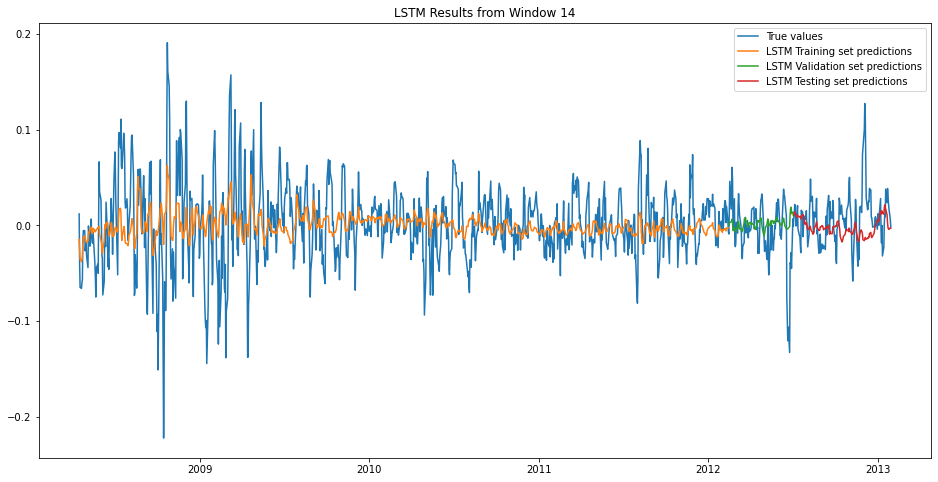

Window 15: 
Training datapoints: 2100 - 3099
Validation datapoints: 3100 - 3199
Testing datapoints: 3200 - 3349

Results on Training set: 
MSE = 0.0009231328451732814
RMSE = 0.03038310130933446
MAE = 0.022454788615950787
R-Squared = 0.25707721108493886

Results on Validation set: 
MSE = 0.000978031695978437
RMSE = 0.031273498300932644
MAE = 0.021471452627548106
R-Squared = -0.11547280252117664

Results on Testing set: 
MSE = 0.0008964112226181624
RMSE = 0.029940127297961885
MAE = 0.025078743159543816
R-Squared = -0.13179968163148081



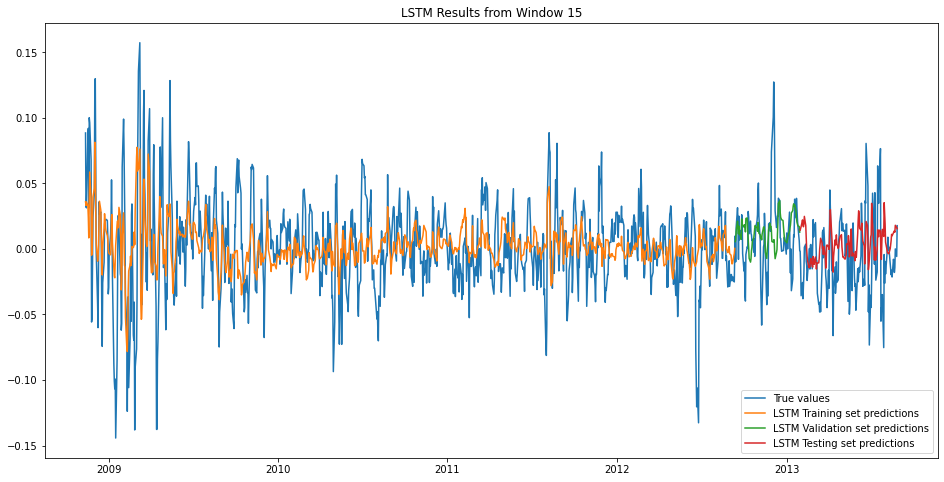

Window 16: 
Training datapoints: 2250 - 3249
Validation datapoints: 3250 - 3349
Testing datapoints: 3350 - 3499

Results on Training set: 
MSE = 0.0007450631062539994
RMSE = 0.02729584412056164
MAE = 0.02087776181146276
R-Squared = 0.0719221925024015

Results on Validation set: 
MSE = 0.0009921432151087206
RMSE = 0.03149830495611979
MAE = 0.026274507023093287
R-Squared = -0.043104464199808845

Results on Testing set: 
MSE = 0.0009289621501194175
RMSE = 0.030478880394781853
MAE = 0.024568782928637508
R-Squared = -0.03315277857344845



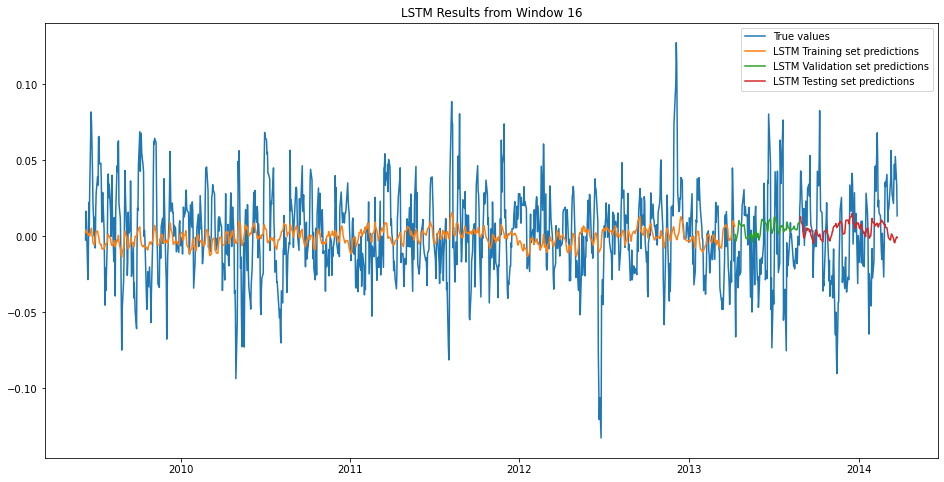

Window 17: 
Training datapoints: 2400 - 3399
Validation datapoints: 3400 - 3499
Testing datapoints: 3500 - 3649

Results on Training set: 
MSE = 0.0007312331806033482
RMSE = 0.02704132357343753
MAE = 0.0207049898521204
R-Squared = 0.05129286608157457

Results on Validation set: 
MSE = 0.0010220747088092474
RMSE = 0.031969903171721485
MAE = 0.025968306074141346
R-Squared = -0.03719001884849704

Results on Testing set: 
MSE = 0.00045022100372098175
RMSE = 0.02121841190383912
MAE = 0.01625278084541068
R-Squared = 0.08849947073857345



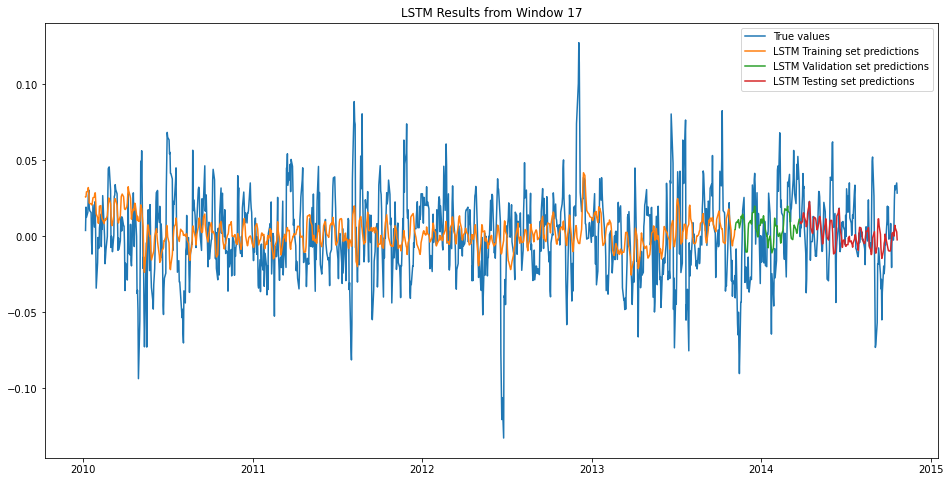

Window 18: 
Training datapoints: 2550 - 3549
Validation datapoints: 3550 - 3649
Testing datapoints: 3650 - 3799

Results on Training set: 
MSE = 0.0002873318520366099
RMSE = 0.016950865819674518
MAE = 0.012348895913335864
R-Squared = 0.6216640232197642

Results on Validation set: 
MSE = 0.0004318610582054433
RMSE = 0.020781267001928522
MAE = 0.015989704858470004
R-Squared = 0.18519696975638977

Results on Testing set: 
MSE = 0.0029654846968538255
RMSE = 0.05445626407360154
MAE = 0.04288788434501789
R-Squared = -1.495509762815964



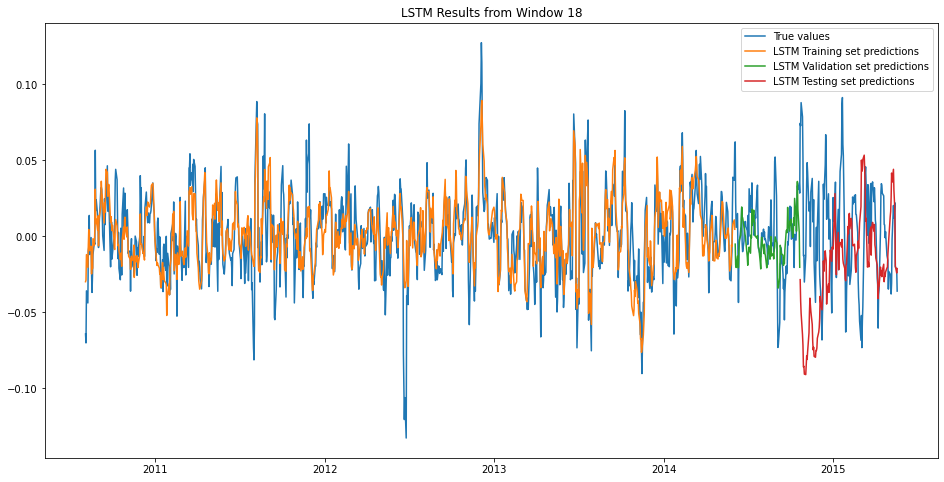

Window 19: 
Training datapoints: 2700 - 3699
Validation datapoints: 3700 - 3799
Testing datapoints: 3800 - 3949

Results on Training set: 
MSE = 0.0007726653983086819
RMSE = 0.02779685950442391
MAE = 0.02112236909176882
R-Squared = 0.04614621835086563

Results on Validation set: 
MSE = 0.0011252037464675633
RMSE = 0.03354405679800169
MAE = 0.027882953082712804
R-Squared = -0.018383566911195803

Results on Testing set: 
MSE = 0.0015671061599970314
RMSE = 0.03958669170310941
MAE = 0.028995576212566085
R-Squared = -0.12587764921469735



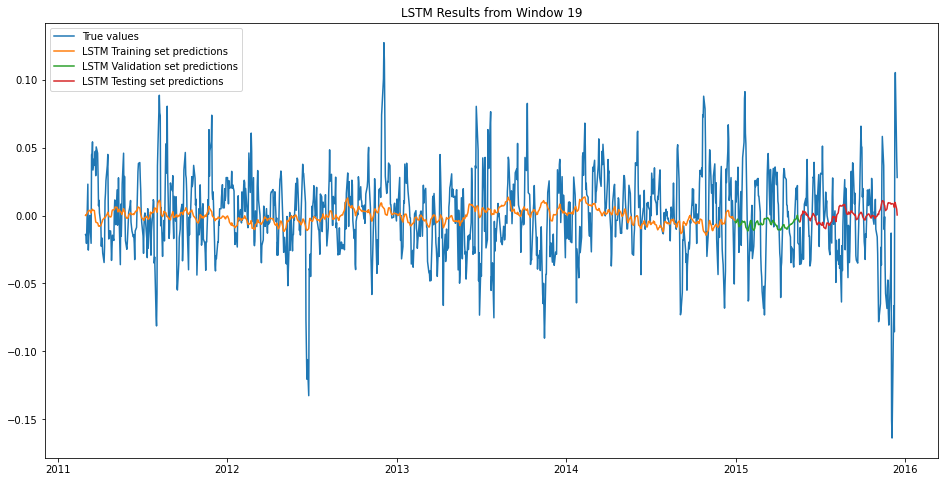

Window 20: 
Training datapoints: 2850 - 3849
Validation datapoints: 3850 - 3949
Testing datapoints: 3950 - 4099

Results on Training set: 
MSE = 0.0007605530742618097
RMSE = 0.02757812673590811
MAE = 0.02095551727002045
R-Squared = 0.07676299464651437

Results on Validation set: 
MSE = 0.002073893138357162
RMSE = 0.04554001689017212
MAE = 0.03327253709537157
R-Squared = -0.17515428879943795

Results on Testing set: 
MSE = 0.0031111321845138087
RMSE = 0.055777524008455315
MAE = 0.045692936004051055
R-Squared = -0.1053666088854528



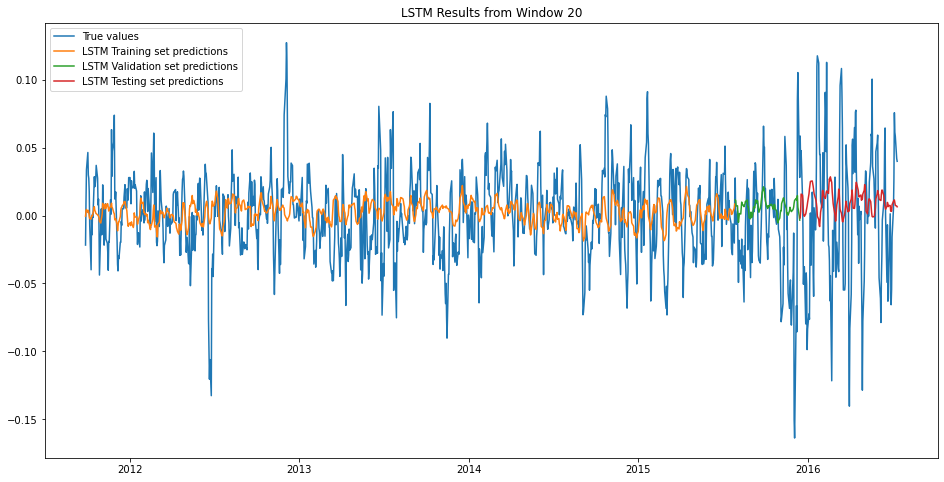

Window 21: 
Training datapoints: 3000 - 3999
Validation datapoints: 4000 - 4099
Testing datapoints: 4100 - 4249

Results on Training set: 
MSE = 0.0009605595208393475
RMSE = 0.03099289468312612
MAE = 0.02333042511939261
R-Squared = 0.13316284865513106

Results on Validation set: 
MSE = 0.0025548344412773412
RMSE = 0.050545370127018964
MAE = 0.04012236901699771
R-Squared = -0.0014088019950075914

Results on Testing set: 
MSE = 0.0013226019964242457
RMSE = 0.03636759541713262
MAE = 0.029639039399018855
R-Squared = -0.17757321464364373



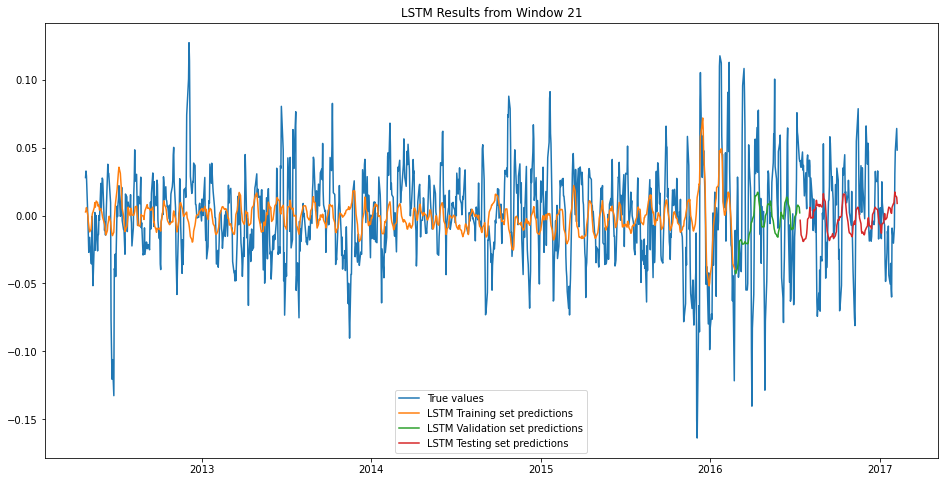

Window 22: 
Training datapoints: 3150 - 4149
Validation datapoints: 4150 - 4249
Testing datapoints: 4250 - 4399

Results on Training set: 
MSE = 0.0007006826109177293
RMSE = 0.026470410101049235
MAE = 0.019290324755770576
R-Squared = 0.4594217388430132

Results on Validation set: 
MSE = 0.001048383132632516
RMSE = 0.03237874507501049
MAE = 0.02514629101277136
R-Squared = 0.01366366130626473

Results on Testing set: 
MSE = 0.0009890865354792182
RMSE = 0.031449746191014295
MAE = 0.025545471823430598
R-Squared = 0.01067428373725865



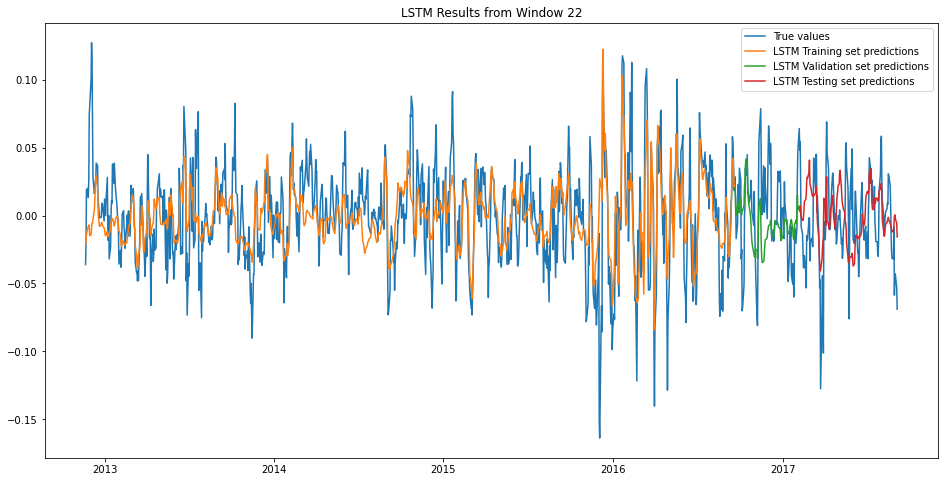

Window 23: 
Training datapoints: 3300 - 4299
Validation datapoints: 4300 - 4399
Testing datapoints: 4400 - 4549

Results on Training set: 
MSE = 0.0011764292391834557
RMSE = 0.034299114262374995
MAE = 0.026334120349330255
R-Squared = 0.12768181719015026

Results on Validation set: 
MSE = 0.0006738317609200147
RMSE = 0.025958269605657745
MAE = 0.020236909949300098
R-Squared = 0.053136433973205666

Results on Testing set: 
MSE = 0.0021300312241691916
RMSE = 0.04615226131154563
MAE = 0.03403183339489876
R-Squared = -0.04234670311490207



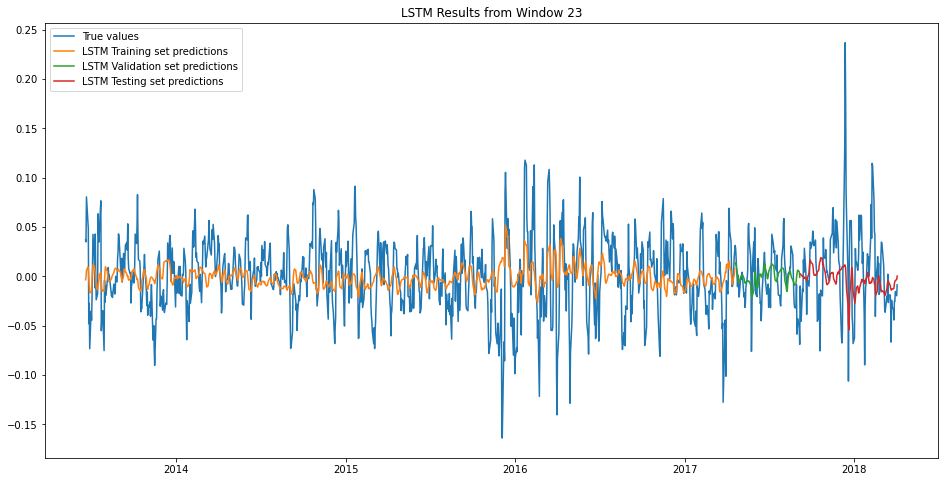

Window 24: 
Training datapoints: 3450 - 4449
Validation datapoints: 4450 - 4549
Testing datapoints: 4550 - 4699

Results on Training set: 
MSE = 0.0010053655567129852
RMSE = 0.03170750000730088
MAE = 0.023896896069855064
R-Squared = 0.23135214919674885

Results on Validation set: 
MSE = 0.0024021267452806476
RMSE = 0.04901149605225949
MAE = 0.03583073555270253
R-Squared = 0.09647866583618847

Results on Testing set: 
MSE = 0.0015734635614998971
RMSE = 0.03966690763722195
MAE = 0.03120226224178964
R-Squared = -0.032008929724870905



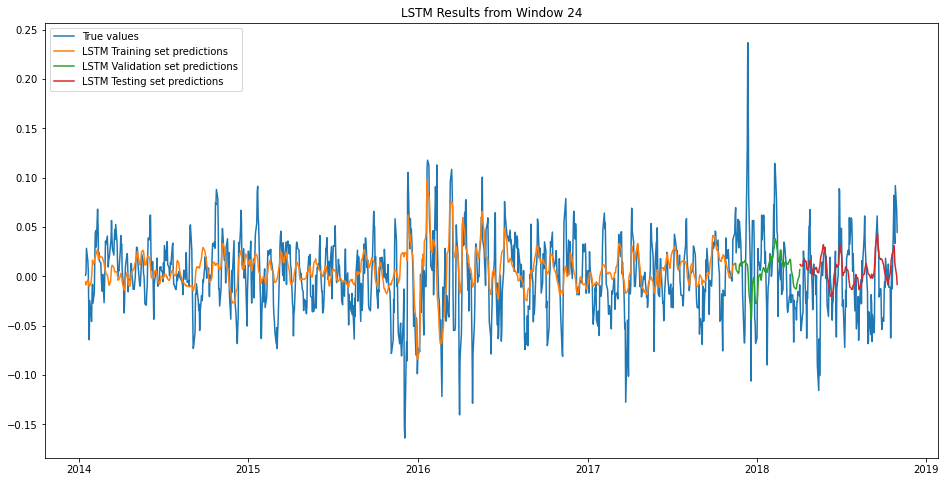

Window 25: 
Training datapoints: 3600 - 4599
Validation datapoints: 4600 - 4699
Testing datapoints: 4700 - 4849

Results on Training set: 
MSE = 0.0014636723470699007
RMSE = 0.03825797102657041
MAE = 0.029671437005727993
R-Squared = 0.07373306123803958

Results on Validation set: 
MSE = 0.00118012338223058
RMSE = 0.034352923925491115
MAE = 0.026964284188252443
R-Squared = 0.23258371799369426

Results on Testing set: 
MSE = 0.001861363650142916
RMSE = 0.043143523849390374
MAE = 0.034466784524090334
R-Squared = -0.22837432110771738



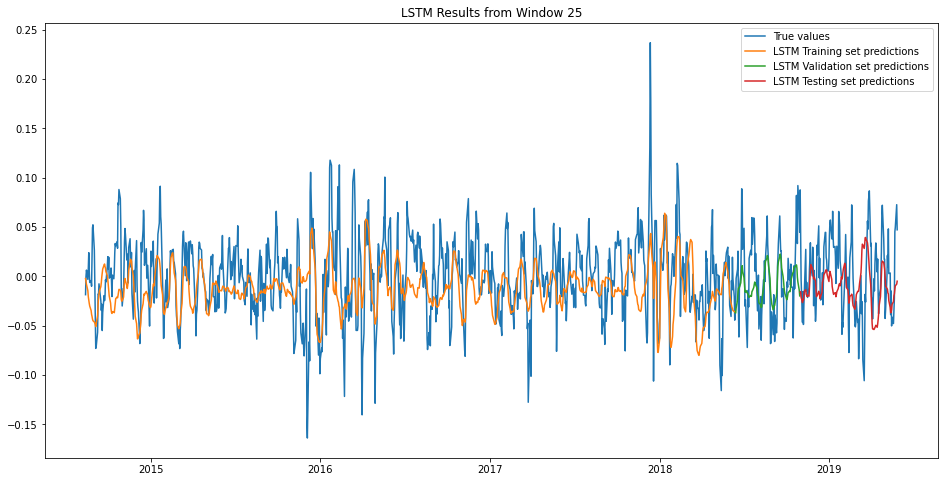

Window 26: 
Training datapoints: 3750 - 4749
Validation datapoints: 4750 - 4849
Testing datapoints: 4850 - 4999

Results on Training set: 
MSE = 0.0015189480734997664
RMSE = 0.03897368437163423
MAE = 0.029465720016616494
R-Squared = 0.05052693638574823

Results on Validation set: 
MSE = 0.0018059919462956075
RMSE = 0.04249696396562474
MAE = 0.03478967260547126
R-Squared = -0.0030004948170663237

Results on Testing set: 
MSE = 0.0015507355018826
RMSE = 0.03937937914546902
MAE = 0.03266106809496314
R-Squared = -0.2318222476189571



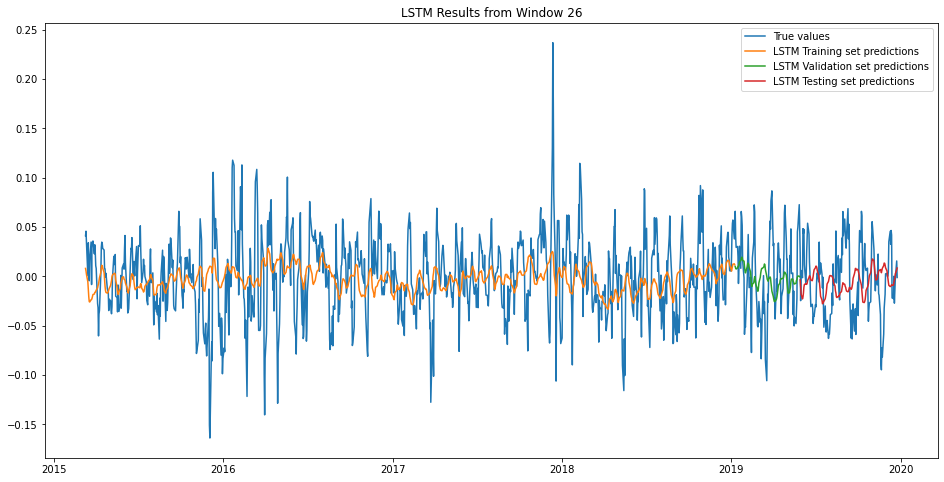

In [7]:
dataset = df.values
totaldatapoints = len(dataset)

#Declaring model parameters
sequencelength = 119
features = len(df.columns) - 1
scaler = MinMaxScaler(feature_range=(-1, 1))

#Window Variables
start = 0 + sequencelength
trainingSize = 1000
validationSize = 100
testingSize = 150
end = trainingSize + validationSize + testingSize + sequencelength
numWindows = int((totaldatapoints - sequencelength - trainingSize - validationSize) / testingSize)
numPredictions = numWindows * testingSize
extra = totaldatapoints - numPredictions - trainingSize - validationSize - sequencelength
lstm_predictions = np.zeros((numPredictions + extra,1)) 
lstm_target = np.zeros((numPredictions + extra,1)) 

for w in range(numWindows):

  #Add the extra datapoints to the test set for the final window
  if w == (numWindows - 1):
    testingSize += extra
    end += extra

  #Print window information
  windowInfo(w, sequencelength, start, trainingSize, validationSize, end)
  
  #Get train, validation and test sets
  scaler, x_train, y_train, y_trainUnscaled, x_val, y_val, y_valUnscaled, x_test, y_test = split(dataset, sequencelength, features, scaler, start, trainingSize, validationSize, testingSize, end)

  #Create, train and test LSTM
  lstm_model = create_lstm()
  lstm_history, lstm_model = train_lstm(lstm_model, x_train, y_train, x_val, y_val)
  lstm_predictions, lstm_trainingPredictions, lstm_valPredictions, lstm_testingPredictions = makePredictions(lstm_model, lstm_predictions, x_train, x_val, x_test)
  evaluate_model(y_trainUnscaled, y_valUnscaled, y_test, lstm_trainingPredictions, lstm_valPredictions, lstm_testingPredictions)

  lstm_target[start - sequencelength: start - sequencelength + testingSize, :] = y_test.reshape((y_test.shape[0],1))

  #Plot graph of forecasts
  trainGraph = pd.DataFrame(df[start : start + trainingSize])
  trainGraph['LSTM Train Predictions'] = lstm_trainingPredictions
  valGraph = pd.DataFrame(df[start + trainingSize : end - testingSize])
  valGraph['LSTM Val Predictions'] = lstm_valPredictions
  testGraph = pd.DataFrame(df[start + trainingSize + validationSize : end])
  testGraph['LSTM Test Predictions'] = lstm_testingPredictions

  #Plot LSTM Results
  plt.figure(figsize=(16,8))
  plt.plot(df['Target'][start : end], label='True values')
  plt.plot(trainGraph['LSTM Train Predictions'], label = 'LSTM Training set predictions')
  plt.plot(valGraph['LSTM Val Predictions'], label = 'LSTM Validation set predictions')
  plt.plot(testGraph['LSTM Test Predictions'], label = 'LSTM Testing set predictions')
  plt.title("LSTM Results from Window " + str(w + 1))
  plt.legend(loc = 'best')
  plt.show()

  #Update window parameters
  start += testingSize
  end += testingSize

In [8]:
K.clear_session()
tf.compat.v1.reset_default_graph()

**GRU model**

In [9]:
def create_gru():
  '''
  Function to create an GRU using the Keras Framework
  @returns
    model - Compiled GRU
  '''
  #hyperparameters
  learningRate = 0.0024768316121782804
  dropout = 0.015770349364863216
  units = 166

  #Construct GRU
  model = Sequential()
  model.add(GRU(units=units, return_sequences=True, input_shape=(sequencelength, features)))
  model.add(GRU(units=units, dropout=dropout))
  model.add(Dense(1))

  #GRU compile
  ao = Adam(lr=learningRate, amsgrad=True)
  model.compile(loss='mae', optimizer=ao, metrics=['mse','mae', 'mape', 'msle'])

  return model

def train_gru(model, x_train, y_train, x_val, y_val):
  '''
  Function to train the LSTM
  @params:
    model - Keras LSTM model
    x_train - Training Input
    y_train - Training Output
    x_val - Validation Input
    y_val - Validation Output
  @returns:
    history - Model history
    model - Best model according to early stopping
  '''
  batchSize = 83
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=20)
  mc = ModelCheckpoint('./GRU.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
  history = model.fit(x_train, y_train, epochs=150, batch_size=batchSize, verbose=0, validation_data = (x_val, y_val), callbacks=[es, mc])
  model = load_model('./GRU.h5')
  return history, model

**GRU Forecasting Implementation**

Window 1: 
Training datapoints: 0 - 999
Validation datapoints: 1000 - 1099
Testing datapoints: 1100 - 1249

Results on Training set: 
MSE = 0.0021271985332983415
RMSE = 0.04612156256349455
MAE = 0.03303416643574474
R-Squared = -0.01607442316134744

Results on Validation set: 
MSE = 0.0005956372058732321
RMSE = 0.02440567978715676
MAE = 0.01960563411023854
R-Squared = 0.009585200247308023

Results on Testing set: 
MSE = 0.0009620071582751453
RMSE = 0.031016240234353766
MAE = 0.02388550608553932
R-Squared = -0.17329001961990098



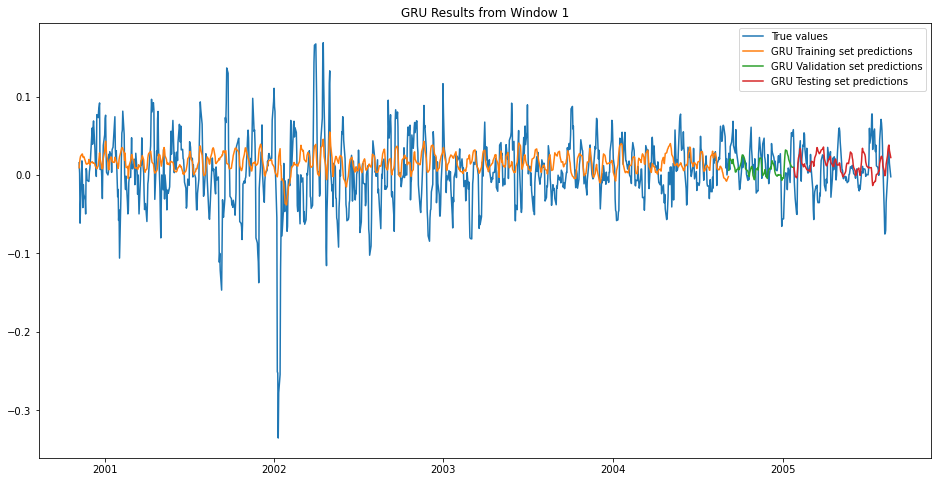

Window 2: 
Training datapoints: 150 - 1149
Validation datapoints: 1150 - 1249
Testing datapoints: 1250 - 1399

Results on Training set: 
MSE = 0.0019075465525662798
RMSE = 0.04367546854432451
MAE = 0.030761427788880125
R-Squared = 0.02845171267347557

Results on Validation set: 
MSE = 0.0008545915996469677
RMSE = 0.02923339870160443
MAE = 0.020165427817796035
R-Squared = -0.06653271292659291

Results on Testing set: 
MSE = 0.001224206511937024
RMSE = 0.03498866262001199
MAE = 0.028919855622919932
R-Squared = 0.005691072951395704



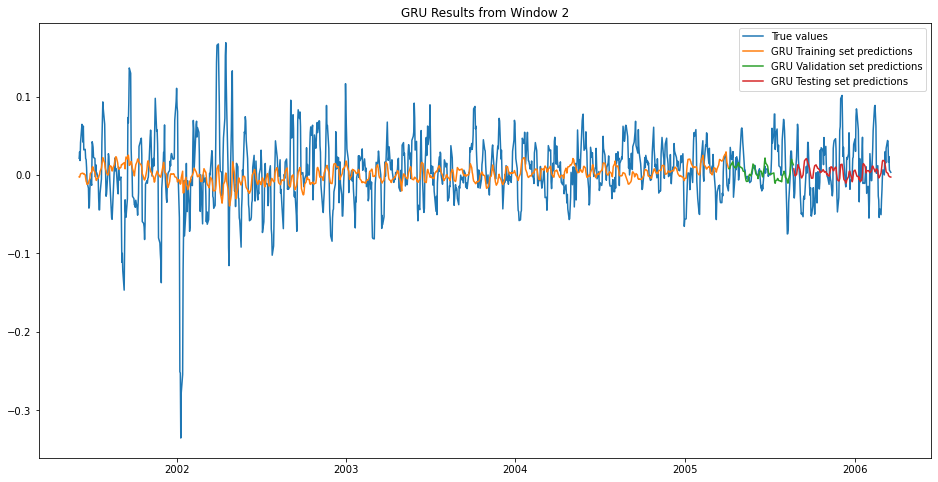

Window 3: 
Training datapoints: 300 - 1299
Validation datapoints: 1300 - 1399
Testing datapoints: 1400 - 1549

Results on Training set: 
MSE = 0.0012176582556622383
RMSE = 0.034894960318966384
MAE = 0.024088031736337952
R-Squared = 0.2988887171155359

Results on Validation set: 
MSE = 0.0010215458260804634
RMSE = 0.03196163052912763
MAE = 0.026592542814655208
R-Squared = 0.1600133663901575

Results on Testing set: 
MSE = 0.002607200028165349
RMSE = 0.051060748409765294
MAE = 0.03801045988032488
R-Squared = -0.09615254576107946



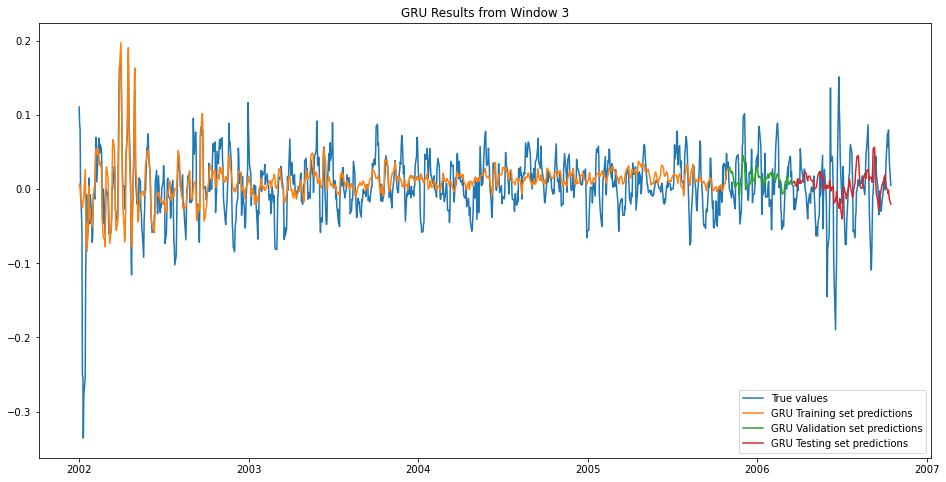

Window 4: 
Training datapoints: 450 - 1449
Validation datapoints: 1450 - 1549
Testing datapoints: 1550 - 1699

Results on Training set: 
MSE = 0.0009641275131329107
RMSE = 0.03105040278535708
MAE = 0.024167558040704185
R-Squared = 0.05228269557387799

Results on Validation set: 
MSE = 0.0027540425619832117
RMSE = 0.05247897256981325
MAE = 0.03809380528648349
R-Squared = 0.1369362659279535

Results on Testing set: 
MSE = 0.0013653577311353343
RMSE = 0.03695074736910384
MAE = 0.030243335622374187
R-Squared = -0.1082348891985514



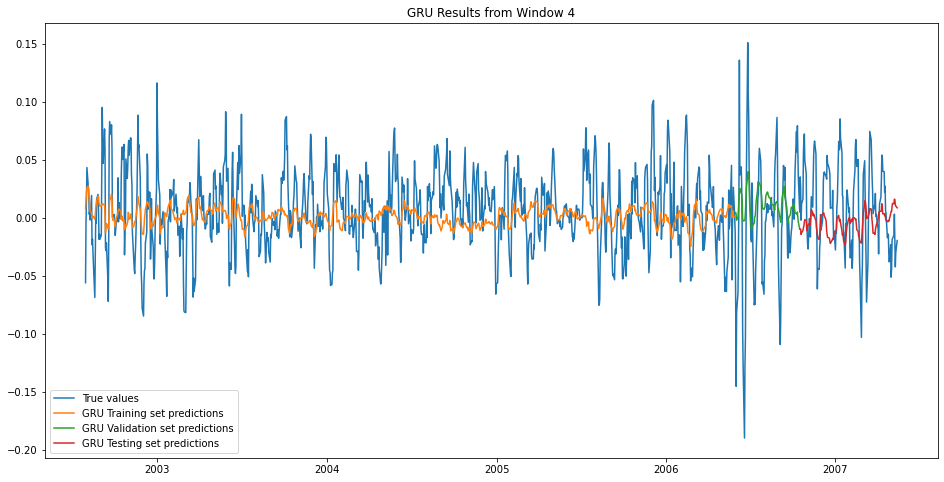

Window 5: 
Training datapoints: 600 - 1599
Validation datapoints: 1600 - 1699
Testing datapoints: 1700 - 1849

Results on Training set: 
MSE = 0.0010841045340201124
RMSE = 0.03292574272541338
MAE = 0.024968094824650112
R-Squared = 0.07055857793470521

Results on Validation set: 
MSE = 0.0012204913432917104
RMSE = 0.0349355312438742
MAE = 0.028298514371479688
R-Squared = 0.05877087502017353

Results on Testing set: 
MSE = 0.0017213815738736566
RMSE = 0.04148953571533016
MAE = 0.033815941640693244
R-Squared = -0.06620765023963648



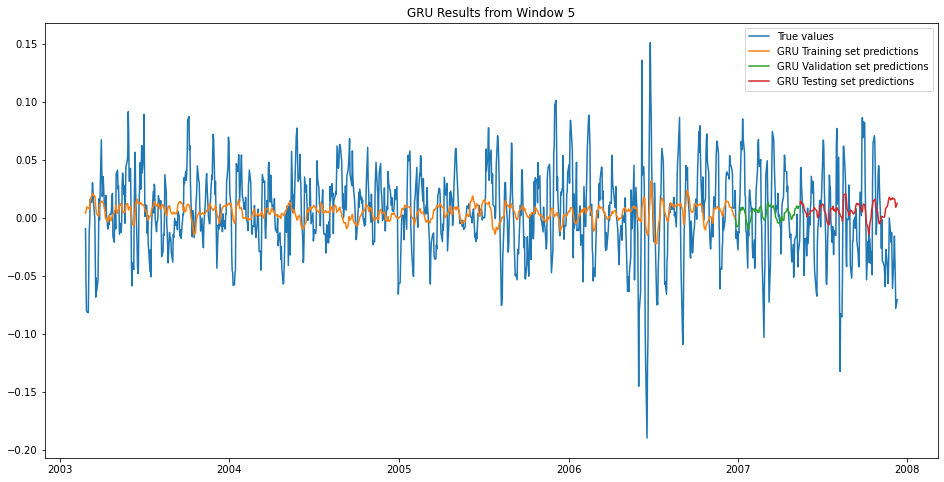

Window 6: 
Training datapoints: 750 - 1749
Validation datapoints: 1750 - 1849
Testing datapoints: 1850 - 1999

Results on Training set: 
MSE = 0.0011208553997520648
RMSE = 0.033479178600319105
MAE = 0.025744054021022155
R-Squared = 0.06555352509128387

Results on Validation set: 
MSE = 0.0018746043580533985
RMSE = 0.04329670146851142
MAE = 0.03516403505421009
R-Squared = -0.02799509964696667

Results on Testing set: 
MSE = 0.002721230473427733
RMSE = 0.05216541453326843
MAE = 0.04305181938663868
R-Squared = -0.48367497087683553



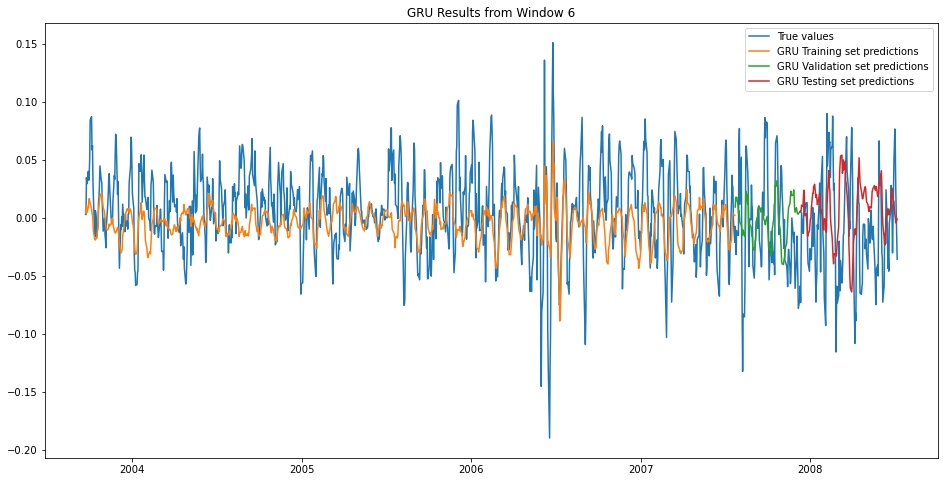

Window 7: 
Training datapoints: 900 - 1899
Validation datapoints: 1900 - 1999
Testing datapoints: 2000 - 2149

Results on Training set: 
MSE = 0.0014549638382142394
RMSE = 0.0381439882316236
MAE = 0.029676569000272636
R-Squared = -0.06171127990542824

Results on Validation set: 
MSE = 0.0021053310958491973
RMSE = 0.04588388710483449
MAE = 0.038917970722424367
R-Squared = -0.13893791430978153

Results on Testing set: 
MSE = 0.005014310314832848
RMSE = 0.07081179502620201
MAE = 0.056770662462004795
R-Squared = -0.08718045944973163



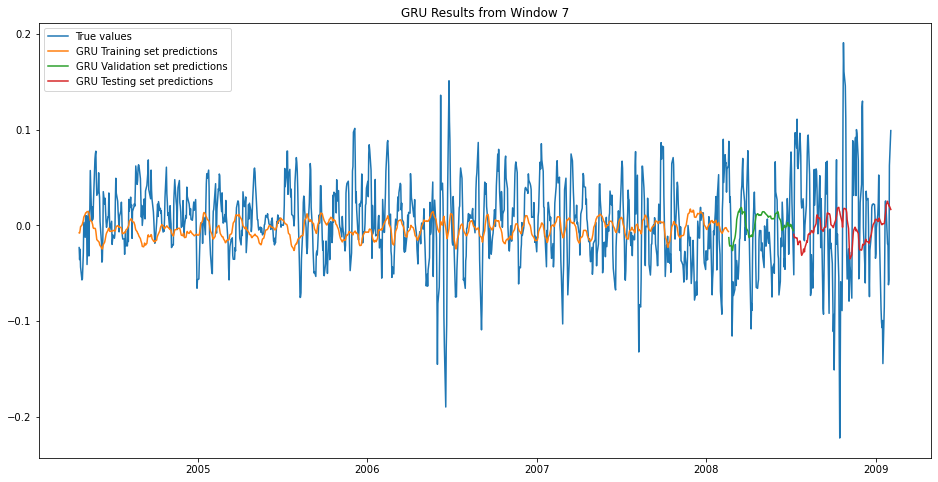

Window 8: 
Training datapoints: 1050 - 2049
Validation datapoints: 2050 - 2149
Testing datapoints: 2150 - 2299

Results on Training set: 
MSE = 0.0014229223300544418
RMSE = 0.037721642727411034
MAE = 0.0291377317737497
R-Squared = 0.12097711444512371

Results on Validation set: 
MSE = 0.003951216116238105
RMSE = 0.0628586996066424
MAE = 0.048976580901884
R-Squared = 0.24549377217288737

Results on Testing set: 
MSE = 0.0025797080817333627
RMSE = 0.05079082674788197
MAE = 0.03772676610490425
R-Squared = 0.0902065598541707



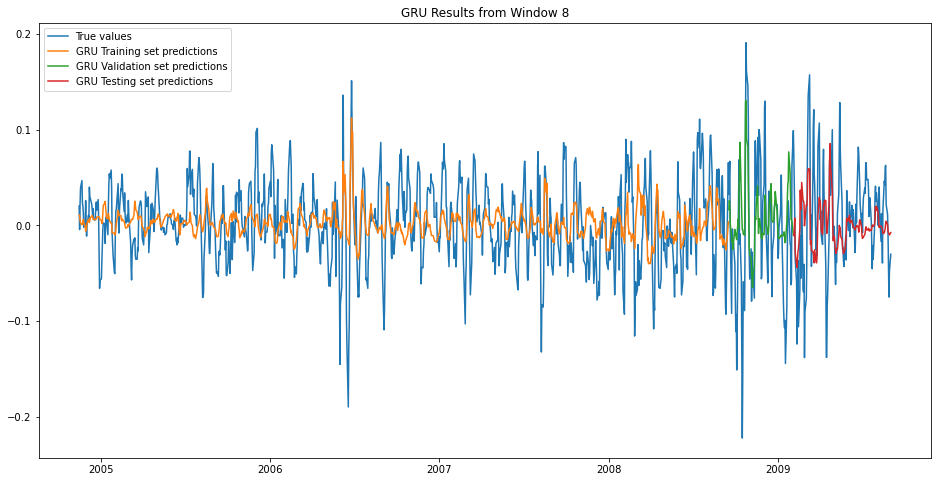

Window 9: 
Training datapoints: 1200 - 2199
Validation datapoints: 2200 - 2299
Testing datapoints: 2300 - 2449

Results on Training set: 
MSE = 0.0020494976170304345
RMSE = 0.04527137745894678
MAE = 0.03499174158505781
R-Squared = 0.10166902558977065

Results on Validation set: 
MSE = 0.0016999248689494523
RMSE = 0.04123014514829474
MAE = 0.029843534693919333
R-Squared = 0.12799026016369663

Results on Testing set: 
MSE = 0.000805995420932166
RMSE = 0.028390058487649614
MAE = 0.021922246819446302
R-Squared = -0.08601668488228031



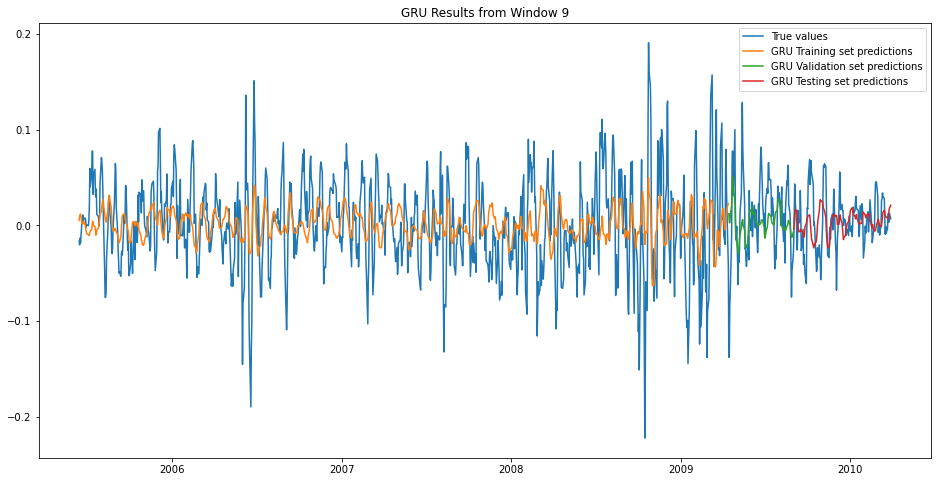

Window 10: 
Training datapoints: 1350 - 2349
Validation datapoints: 2350 - 2449
Testing datapoints: 2450 - 2599

Results on Training set: 
MSE = 0.0021248207019716847
RMSE = 0.04609577748527174
MAE = 0.03600857326790759
R-Squared = 0.09745792414911625

Results on Validation set: 
MSE = 0.0003659548488260545
RMSE = 0.019129946388478314
MAE = 0.014532260731882232
R-Squared = 0.04426478544333068

Results on Testing set: 
MSE = 0.0011066426432481623
RMSE = 0.033266238790223376
MAE = 0.0269884389713994
R-Squared = -0.12214603213710906



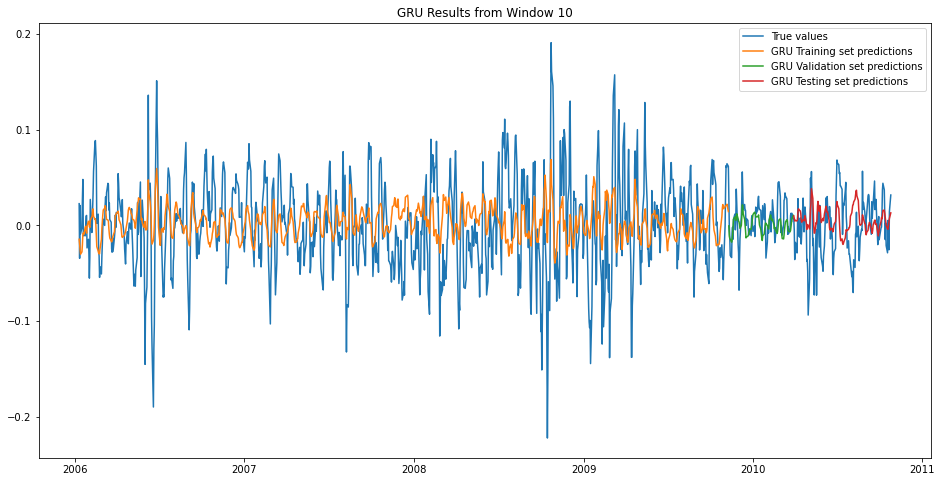

Window 11: 
Training datapoints: 1500 - 2499
Validation datapoints: 2500 - 2599
Testing datapoints: 2600 - 2749

Results on Training set: 
MSE = 0.002022806082807102
RMSE = 0.04497561653615326
MAE = 0.034702101550379796
R-Squared = 0.042206339311163577

Results on Validation set: 
MSE = 0.0009494425599714475
RMSE = 0.030813025816551147
MAE = 0.024622660489824578
R-Squared = -0.06786218002996747

Results on Testing set: 
MSE = 0.00046634196019200387
RMSE = 0.02159495219239913
MAE = 0.017526947417272377
R-Squared = 0.03670854560106829



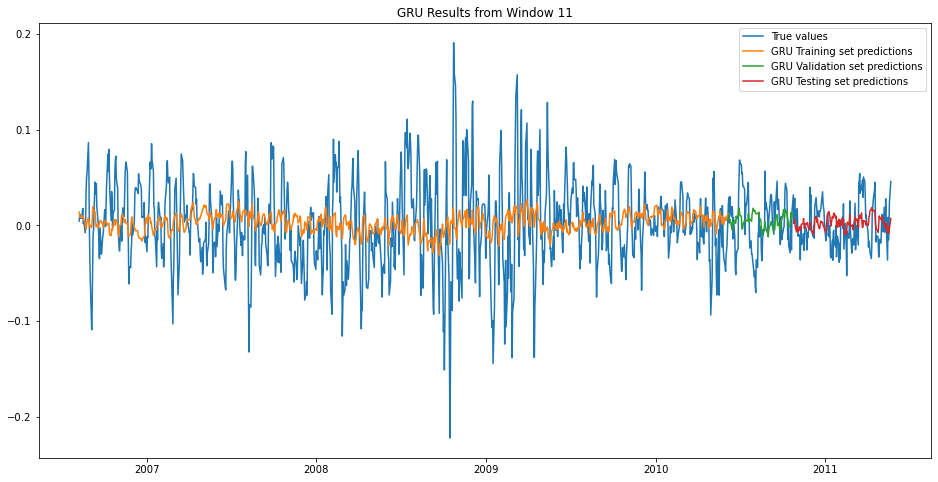

Window 12: 
Training datapoints: 1650 - 2649
Validation datapoints: 2650 - 2749
Testing datapoints: 2750 - 2899

Results on Training set: 
MSE = 0.0016119407356958246
RMSE = 0.04014898175166868
MAE = 0.030930593202527397
R-Squared = 0.19281146080666367

Results on Validation set: 
MSE = 0.0005377461217268945
RMSE = 0.023189353628915457
MAE = 0.018517788436360136
R-Squared = 0.05164082485008925

Results on Testing set: 
MSE = 0.0007841917317173203
RMSE = 0.028003423571365704
MAE = 0.021573411078940327
R-Squared = 0.05928062417782487



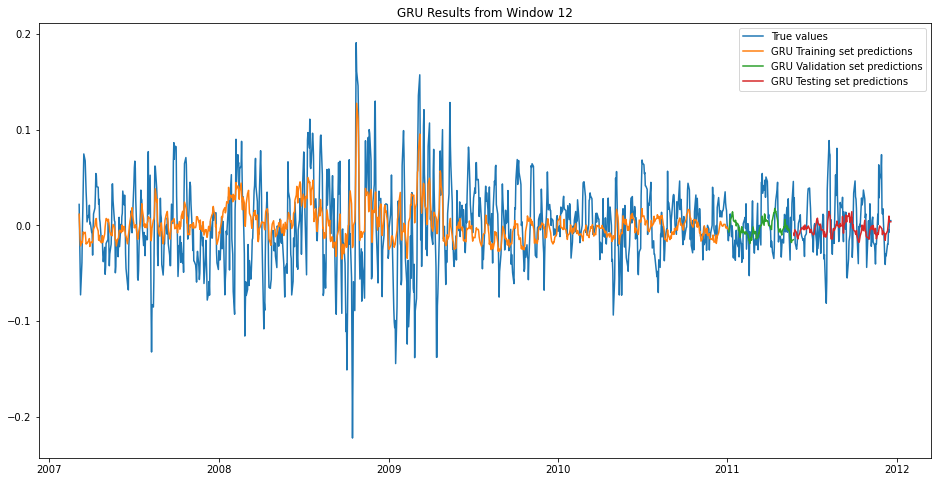

Window 13: 
Training datapoints: 1800 - 2799
Validation datapoints: 2800 - 2899
Testing datapoints: 2900 - 3049

Results on Training set: 
MSE = 0.001261021865161021
RMSE = 0.03551086967621352
MAE = 0.025569686802913622
R-Squared = 0.3195489022819017

Results on Validation set: 
MSE = 0.000719622677010489
RMSE = 0.02682578380980673
MAE = 0.020727017606563668
R-Squared = 0.28944933033784104

Results on Testing set: 
MSE = 0.001208293146508046
RMSE = 0.03476051130964627
MAE = 0.025316264537576818
R-Squared = -0.48339192703641287



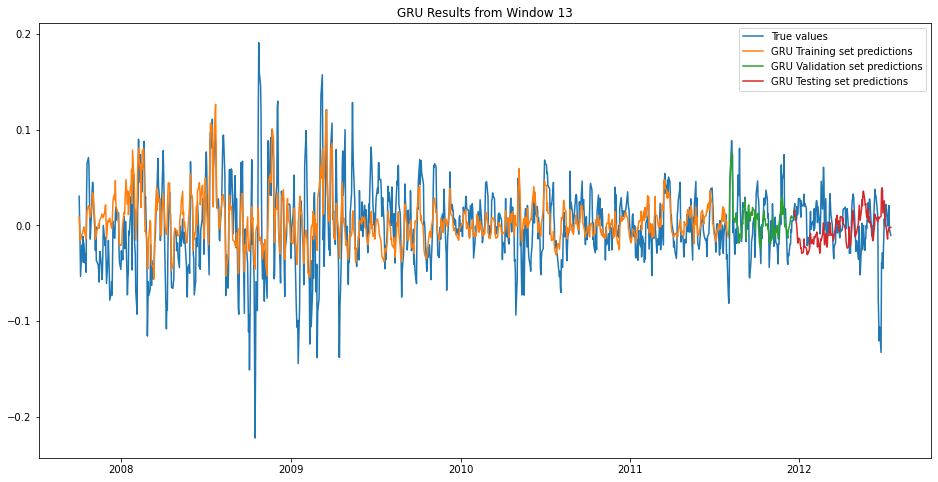

Window 14: 
Training datapoints: 1950 - 2949
Validation datapoints: 2950 - 3049
Testing datapoints: 3050 - 3199

Results on Training set: 
MSE = 0.0014346701212636257
RMSE = 0.03787703949972365
MAE = 0.028002674791008444
R-Squared = 0.1430507327502899

Results on Validation set: 
MSE = 0.001074391926153258
RMSE = 0.032777918270586646
MAE = 0.02233008345213196
R-Squared = -0.14799307372556791

Results on Testing set: 
MSE = 0.000987731454540804
RMSE = 0.031428195216092254
MAE = 0.02262457855838558
R-Squared = -0.27146839839948345



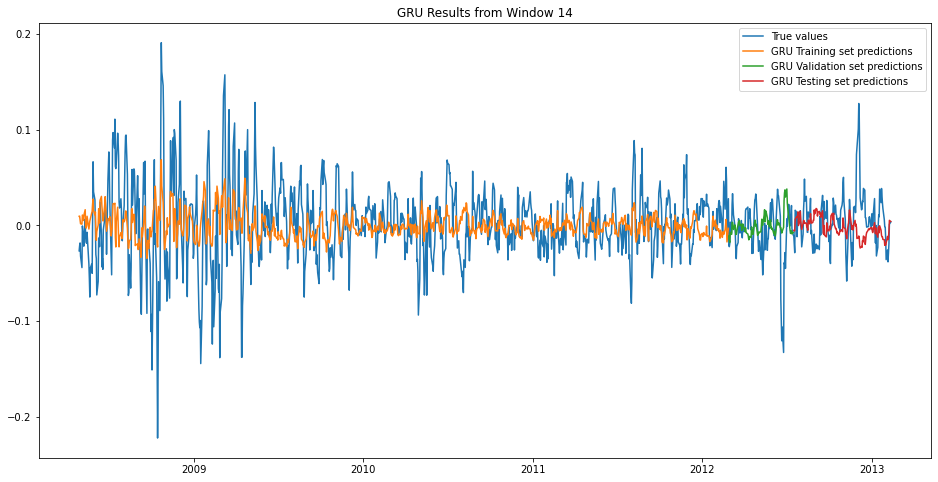

Window 15: 
Training datapoints: 2100 - 3099
Validation datapoints: 3100 - 3199
Testing datapoints: 3200 - 3349

Results on Training set: 
MSE = 0.0011016147551139728
RMSE = 0.033190582325623226
MAE = 0.02430875809646288
R-Squared = 0.0794406857339387

Results on Validation set: 
MSE = 0.0009899420368383106
RMSE = 0.03146334433651818
MAE = 0.02180543403165224
R-Squared = -0.040269786411998076

Results on Testing set: 
MSE = 0.000858207911696341
RMSE = 0.029295185810920214
MAE = 0.024014811239214028
R-Squared = -0.039983372957298036



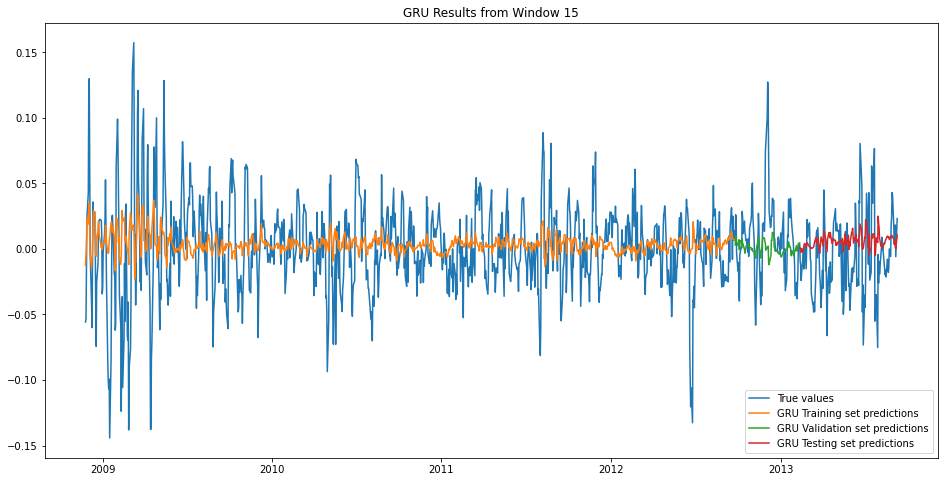

Window 16: 
Training datapoints: 2250 - 3249
Validation datapoints: 3250 - 3349
Testing datapoints: 3350 - 3499

Results on Training set: 
MSE = 0.000832297784970227
RMSE = 0.028849571660082354
MAE = 0.022222614809715595
R-Squared = -0.033990014213125086

Results on Validation set: 
MSE = 0.0008014269056926955
RMSE = 0.028309484377019224
MAE = 0.023312444337994384
R-Squared = 0.14342245973692724

Results on Testing set: 
MSE = 0.0009884541161357984
RMSE = 0.03143969014058183
MAE = 0.025751058148871752
R-Squared = -0.10440026714247397



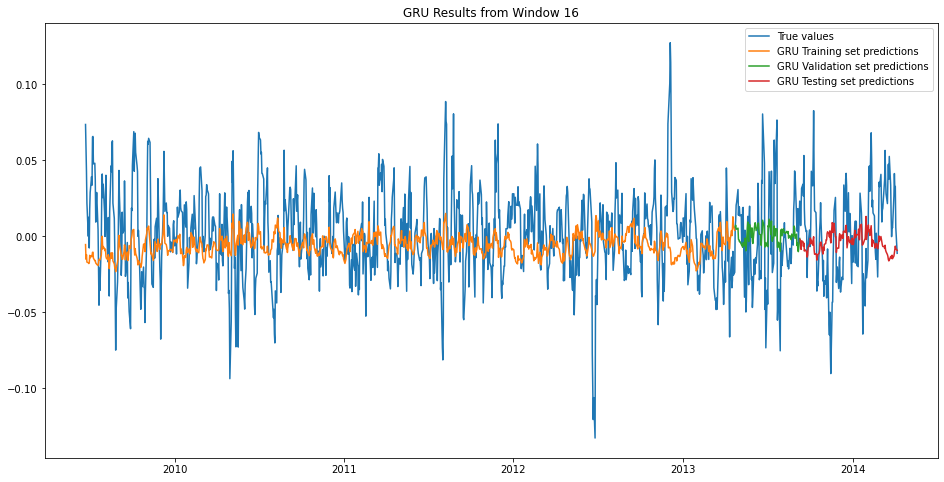

Window 17: 
Training datapoints: 2400 - 3399
Validation datapoints: 3400 - 3499
Testing datapoints: 3500 - 3649

Results on Training set: 
MSE = 0.0007254161665237671
RMSE = 0.026933550945312933
MAE = 0.020195269704129368
R-Squared = 0.08830243507542468

Results on Validation set: 
MSE = 0.0006648247571790945
RMSE = 0.025784195880017173
MAE = 0.02198593230241452
R-Squared = 0.07061743616434146

Results on Testing set: 
MSE = 0.0007224660269327694
RMSE = 0.026878728149463647
MAE = 0.019938388653921727
R-Squared = -0.11472024277668003



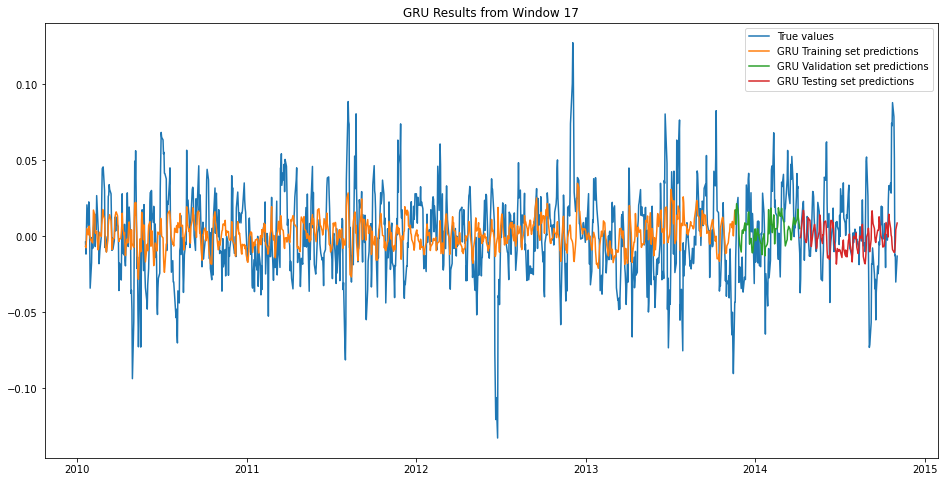

Window 18: 
Training datapoints: 2550 - 3549
Validation datapoints: 3550 - 3649
Testing datapoints: 3650 - 3799

Results on Training set: 
MSE = 0.0006956617199268167
RMSE = 0.02637539990079424
MAE = 0.020011668887148927
R-Squared = 0.07612095069293279

Results on Validation set: 
MSE = 0.0007384713725624096
RMSE = 0.027174829761424626
MAE = 0.019267974883178707
R-Squared = 0.0014478163599548344

Results on Testing set: 
MSE = 0.0011139144212423265
RMSE = 0.03337535649610842
MAE = 0.027169397802290055
R-Squared = -0.07169047109105553



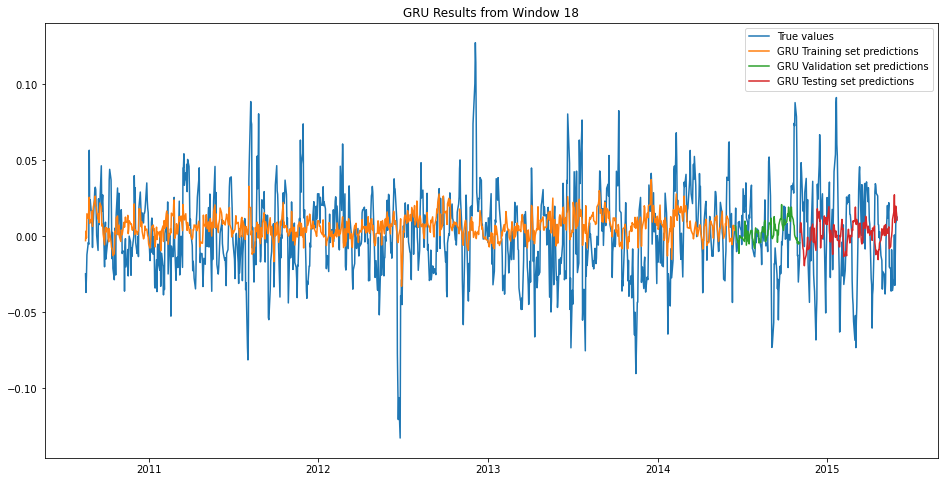

Window 19: 
Training datapoints: 2700 - 3699
Validation datapoints: 3700 - 3799
Testing datapoints: 3800 - 3949

Results on Training set: 
MSE = 0.000776112146741477
RMSE = 0.02785878939834746
MAE = 0.02119998178865261
R-Squared = 0.04232058228884161

Results on Validation set: 
MSE = 0.0011404964586971373
RMSE = 0.03377123715082314
MAE = 0.02742309425420837
R-Squared = -0.029214263810799057

Results on Testing set: 
MSE = 0.0017487425285824087
RMSE = 0.04181796896768671
MAE = 0.029636534977543257
R-Squared = -0.16679844541664135



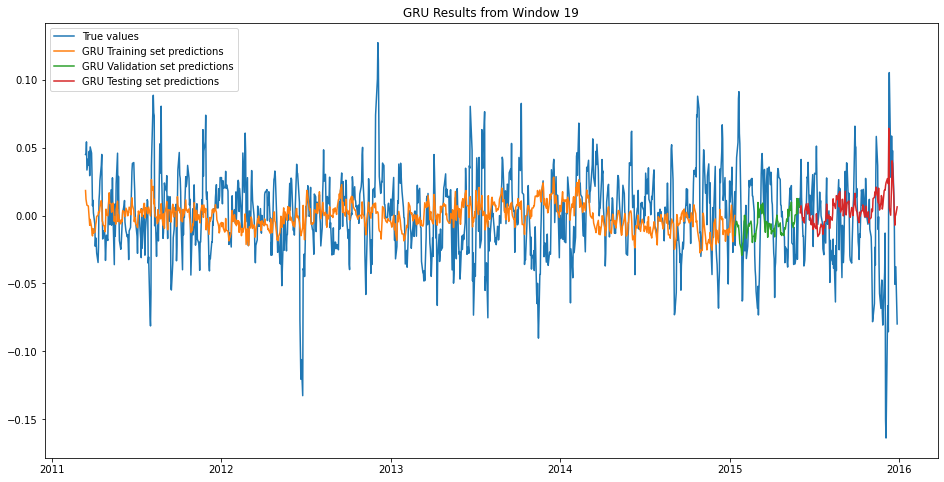

Window 20: 
Training datapoints: 2850 - 3849
Validation datapoints: 3850 - 3949
Testing datapoints: 3950 - 4099

Results on Training set: 
MSE = 0.0008244864314799976
RMSE = 0.028713871760527133
MAE = 0.02204103685442305
R-Squared = -0.001920511466338315

Results on Validation set: 
MSE = 0.0020280471780172683
RMSE = 0.04503384480607078
MAE = 0.033394965149861566
R-Squared = -0.05942386465453886

Results on Testing set: 
MSE = 0.0030765686595214466
RMSE = 0.055466824855236185
MAE = 0.0457190095743137
R-Squared = -0.11865878103023308



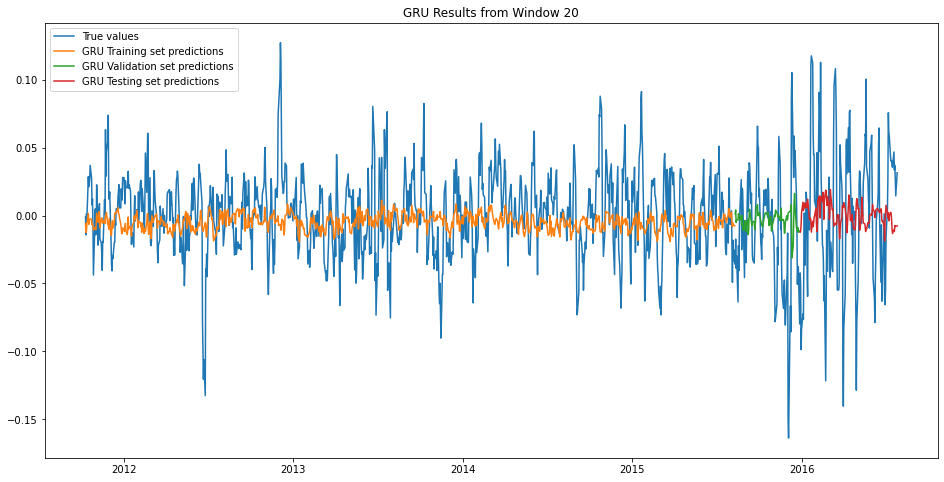

Window 21: 
Training datapoints: 3000 - 3999
Validation datapoints: 4000 - 4099
Testing datapoints: 4100 - 4249

Results on Training set: 
MSE = 0.0011853869394996021
RMSE = 0.034429448724886694
MAE = 0.02579594002432919
R-Squared = -0.06575580768625389

Results on Validation set: 
MSE = 0.002663549524157001
RMSE = 0.05160958752167083
MAE = 0.04139904662377475
R-Squared = -0.0553208948475048

Results on Testing set: 
MSE = 0.0013747497001739852
RMSE = 0.03707761723970386
MAE = 0.028968167763647107
R-Squared = -0.21893469922019526



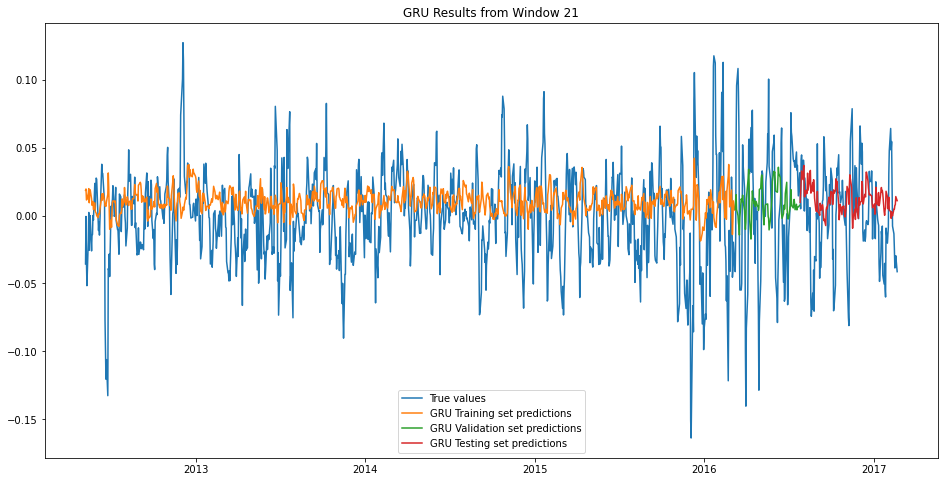

Window 22: 
Training datapoints: 3150 - 4149
Validation datapoints: 4150 - 4249
Testing datapoints: 4250 - 4399

Results on Training set: 
MSE = 0.0011343472656149985
RMSE = 0.0336800722329243
MAE = 0.025571649097747205
R-Squared = 0.10995248899621757

Results on Validation set: 
MSE = 0.0010668837038444088
RMSE = 0.03266318575773663
MAE = 0.02618749117664511
R-Squared = 0.05747308028025111

Results on Testing set: 
MSE = 0.0010400795068378835
RMSE = 0.032250263670827305
MAE = 0.02523700905267652
R-Squared = -0.07520266778045004



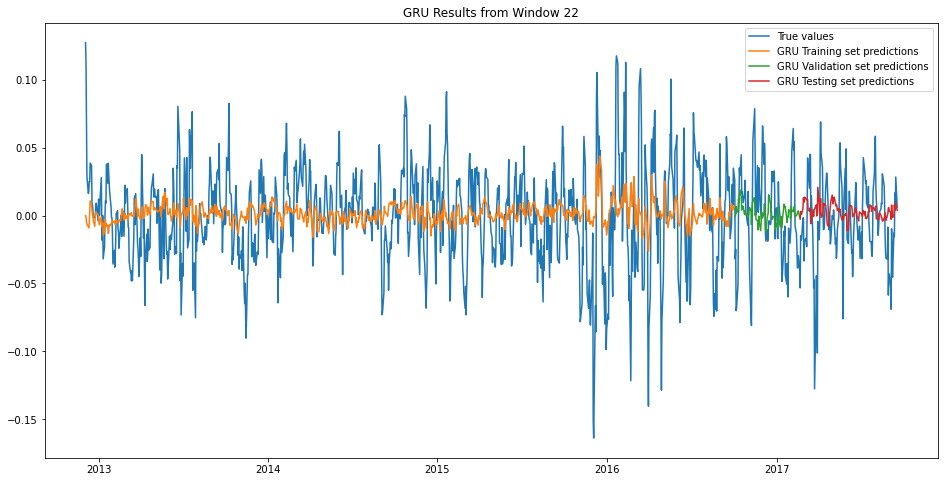

Window 23: 
Training datapoints: 3300 - 4299
Validation datapoints: 4300 - 4399
Testing datapoints: 4400 - 4549

Results on Training set: 
MSE = 0.0013077443011481529
RMSE = 0.03616274742256391
MAE = 0.027905750326489332
R-Squared = 0.014936357095425734

Results on Validation set: 
MSE = 0.0006889381193460242
RMSE = 0.026247630737764205
MAE = 0.020674940077676486
R-Squared = 0.0494959850051343

Results on Testing set: 
MSE = 0.0021735958473451645
RMSE = 0.04662183873835485
MAE = 0.03459726496441339
R-Squared = -0.03684566174742465



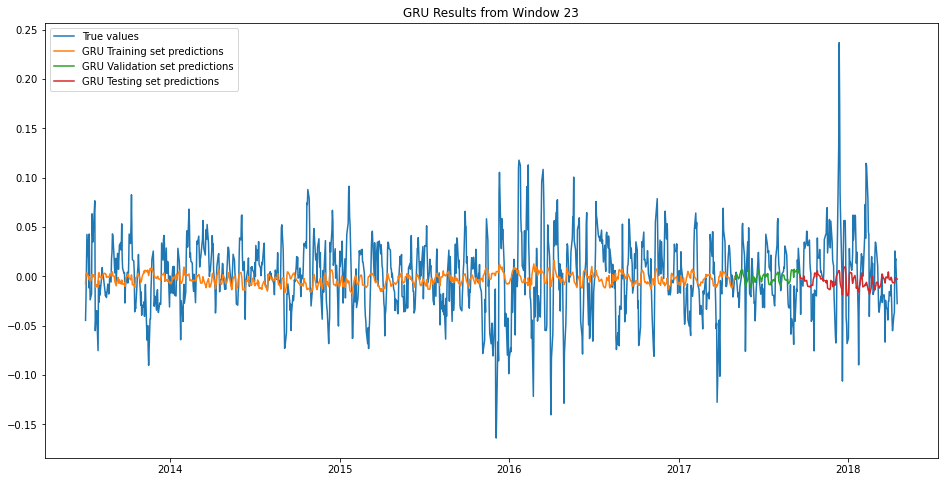

Window 24: 
Training datapoints: 3450 - 4449
Validation datapoints: 4450 - 4549
Testing datapoints: 4550 - 4699

Results on Training set: 
MSE = 0.0012644362170345133
RMSE = 0.035558911921408864
MAE = 0.026887913125391016
R-Squared = 0.04203543510185903

Results on Validation set: 
MSE = 0.0026301988157305793
RMSE = 0.05128546398084528
MAE = 0.03664580780873769
R-Squared = 0.008805669726626442

Results on Testing set: 
MSE = 0.0015972338140589127
RMSE = 0.039965407717911655
MAE = 0.03232805134801464
R-Squared = -0.014680937362361979



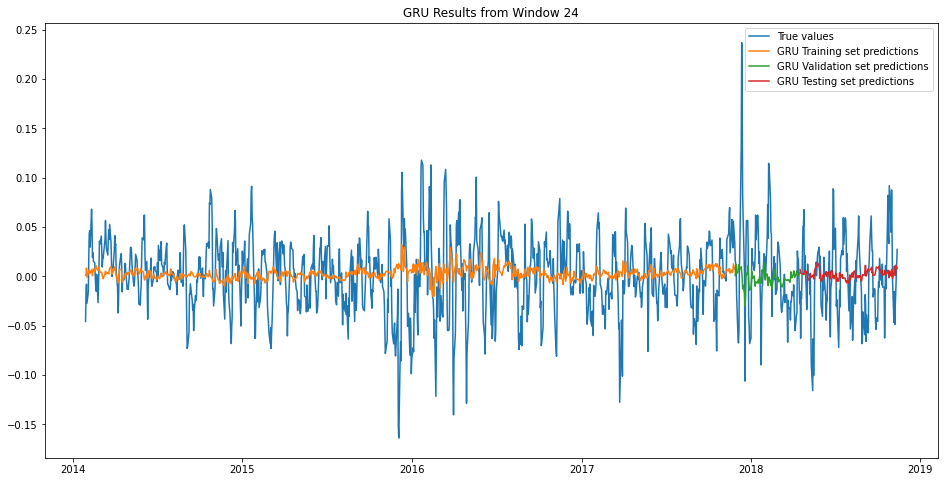

Window 25: 
Training datapoints: 3600 - 4599
Validation datapoints: 4600 - 4699
Testing datapoints: 4700 - 4990

Results on Training set: 
MSE = 0.0015868630823439118
RMSE = 0.039835450070808937
MAE = 0.030740186849813417
R-Squared = -0.00037060320537540825

Results on Validation set: 
MSE = 0.001463574250101983
RMSE = 0.03825668895895178
MAE = 0.03126449139701022
R-Squared = 0.10190498839606932

Results on Testing set: 
MSE = 0.0013889883428967274
RMSE = 0.03726913391664378
MAE = 0.030452725036238616
R-Squared = -0.0038633881028053985



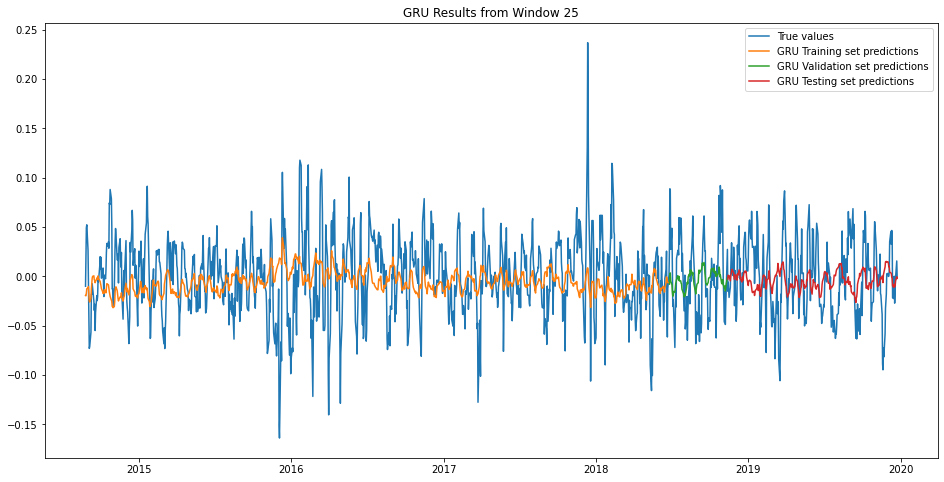

In [10]:
#Declaring model parameters
sequencelength = 128
scaler = MinMaxScaler(feature_range=(-1, 1))

#Window Variables
start = 0 + sequencelength
trainingSize = 1000
validationSize = 100
testingSize = 150
end = trainingSize + validationSize + testingSize + sequencelength
numWindows = int((totaldatapoints - sequencelength - trainingSize - validationSize) / testingSize)
numPredictions = numWindows * testingSize
extra = totaldatapoints - numPredictions - trainingSize - validationSize - sequencelength
gru_predictions = np.zeros((numPredictions + extra,1)) 
gru_target = np.zeros((numPredictions + extra,1)) 

for w in range(numWindows):

  #Add the extra datapoints to the test set for the final window
  if w == (numWindows - 1):
    testingSize += extra
    end += extra

  #Print window information
  windowInfo(w, sequencelength, start, trainingSize, validationSize, end)
  
  #Get train, validation and test sets
  scaler, x_train, y_train, y_trainUnscaled, x_val, y_val, y_valUnscaled, x_test, y_test = split(dataset, sequencelength, features, scaler, start, trainingSize, validationSize, testingSize, end)

  #Create, train and test GRU 
  gru_model = create_gru()
  gru_history, gru_model = train_gru(gru_model, x_train, y_train, x_val, y_val)
  gru_predictions, gru_trainingPredictions, gru_valPredictions, gru_testingPredictions = makePredictions(gru_model, gru_predictions, x_train, x_val, x_test)
  evaluate_model(y_trainUnscaled, y_valUnscaled, y_test, gru_trainingPredictions, gru_valPredictions, gru_testingPredictions)

  gru_target[start - sequencelength: start - sequencelength + testingSize, :] = y_test.reshape((y_test.shape[0],1))

  #Plot graph of forecasts
  trainGraph = pd.DataFrame(df[start : start + trainingSize])
  trainGraph['GRU Train Predictions'] = gru_trainingPredictions
  valGraph = pd.DataFrame(df[start + trainingSize : end - testingSize])
  valGraph['GRU Val Predictions'] = gru_valPredictions
  testGraph = pd.DataFrame(df[start + trainingSize + validationSize : end])
  testGraph['GRU Test Predictions'] = gru_testingPredictions
  
  #Plot GRU Results
  plt.figure(figsize=(16,8))
  plt.plot(df['Target'][start : end], label='True values')
  plt.plot(trainGraph['GRU Train Predictions'], label = 'GRU Training set predictions')
  plt.plot(valGraph['GRU Val Predictions'], label = 'GRU Validation set predictions')
  plt.plot(testGraph['GRU Test Predictions'], label = 'GRU Testing set predictions')
  plt.title("GRU Results from Window " + str(w + 1))
  plt.legend(loc = 'best')
  plt.show()

  #Update window parameters
  start += testingSize
  end += testingSize

**Naive and Drift Forecasting Implementation**

In [11]:
def naiveForecasts(dataset, begin, horizon, testingSize):
  '''
  Naive forecasting model
  @params:
    dataset - data to be used
    begin - Index of the test set
    testingSize - Size of the test set
  @returns:
    naive - forecasts for the window
  '''
  naive = dataset[begin-horizon:begin+testingSize-horizon,0].copy()
  return naive.reshape((naive.shape[0],1))

def driftForecasts(dataset, begin, horizon, testingSize):
  '''
  Drift forecasting model
  @params:
    dataset - data to be used
    begin - Index of the test set
    horizon - Size of the forecasting Horizon
    testingSize - Size of the test set
  @returns:
    drift - forecasts for the window
  '''
  drift = dataset[begin-horizon:begin+testingSize-horizon,0].copy()
  for i in range(2, drift.shape[0] + 1): 
    drift[i - 1] = drift[i - 1] + horizon * ((drift[i - 1] - drift[0]) / (i - 1))
  return drift.reshape((drift.shape[0],1))

#Declaring model parameters
sequencelength = 100
scaler = MinMaxScaler(feature_range=(-1, 1))

#Window Variables
start = 0 + sequencelength
trainingSize = 1000
validationSize = 100
testingSize = 150
end = trainingSize + validationSize + testingSize + sequencelength
numWindows = int((totaldatapoints - sequencelength - trainingSize - validationSize) / testingSize)
numPredictions = numWindows * testingSize
extra = totaldatapoints - numPredictions - trainingSize - validationSize - sequencelength 
naive_predictions = np.zeros((numPredictions + extra,1)) 
drift_predictions = np.zeros((numPredictions + extra,1)) 
target = np.zeros((numPredictions + extra,1)) 

for w in range(numWindows):

  #Add the extra datapoints to the test set for the final window
  if w == (numWindows - 1):
    testingSize += extra
    end += extra
  
  #Get train, validation and test sets
  scaler, x_train, y_train, y_trainUnscaled, x_val, y_val, y_valUnscaled, x_test, y_test = split(dataset, sequencelength, features, scaler, start, trainingSize, validationSize, testingSize, end)

  #naive and drift forecasts
  begin = start + trainingSize + validationSize
  naive_predictions[start - sequencelength: start - sequencelength + testingSize, :] = naiveForecasts(dataset, begin, forecastHorizon, testingSize)
  drift_predictions[start - sequencelength: start - sequencelength + testingSize, :] = driftForecasts(dataset, begin, forecastHorizon, testingSize)
  target[start - sequencelength: start - sequencelength + testingSize, :] = y_test.reshape((y_test.shape[0],1))

  #Update window parameters
  start += testingSize
  end += testingSize

print("Naive and Drift Forecasts completed")

Naive and Drift Forecasts completed


**Overall Results**

In [12]:
def overall(actual, predictions, model):
  '''
  Calculate the overall performance of the model
  @params:
    actual - True Values
    predictions - Predicted Values
    model - Name of the model used
  '''
  mse = mean_squared_error(actual, predictions)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(actual, predictions)
  r2 = r2_score(actual, predictions)

  print(model + " results on the Testing set")
  print('MSE = ' + str(mse))
  print('RMSE = ' + str(rmse))
  print('MAE = ' + str(mae))
  print('R-Squared = ' + str(r2))
  print()

#Performance Metrics
overall(lstm_target, lstm_predictions, "LSTM model")
overall(gru_target, gru_predictions, "GRU model")
overall(target, naive_predictions, "Naive model")
overall(target, drift_predictions, "Drift model")

#For Plots
numpreds = 0
if lstm_predictions.shape[0] <= gru_predictions.shape[0]:
  numpreds = lstm_predictions.shape[0]
else:
  numpreds = gru_predictions.shape[0]

testGraph = pd.DataFrame(df[-numpreds:]['Target'])
testGraph['LSTM'] = lstm_predictions[-numpreds:]
testGraph['GRU'] = gru_predictions[-numpreds:]
testGraph['Naive'] = naive_predictions[-numpreds:]
testGraph['Drift'] = drift_predictions[-numpreds:]

LSTM model results on the Testing set
MSE = 0.0017774581478797544
RMSE = 0.042159911620872195
MAE = 0.03207849260309467
R-Squared = -0.21455771387311517

GRU model results on the Testing set
MSE = 0.0015783827350911966
RMSE = 0.03972886526307033
MAE = 0.030100779270764426
R-Squared = -0.07808427174962151

Naive model results on the Testing set
MSE = 0.0034294781523505143
RMSE = 0.05856174649334252
MAE = 0.04354534039662156
R-Squared = -1.3480714031430945

Drift model results on the Testing set
MSE = 0.004079739188124111
RMSE = 0.06387283607390634
MAE = 0.04734247426517868
R-Squared = -1.7932876357153016



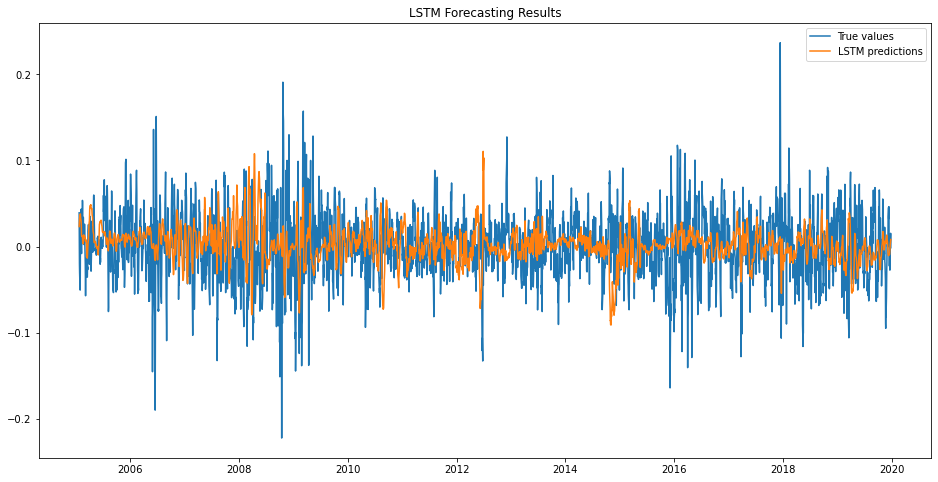

In [13]:
plt.figure(figsize=(16,8))
plt.plot(testGraph['Target'], label='True values')
plt.plot(testGraph['LSTM'], label = 'LSTM predictions')
plt.title("LSTM Forecasting Results")
plt.legend()
plt.show()

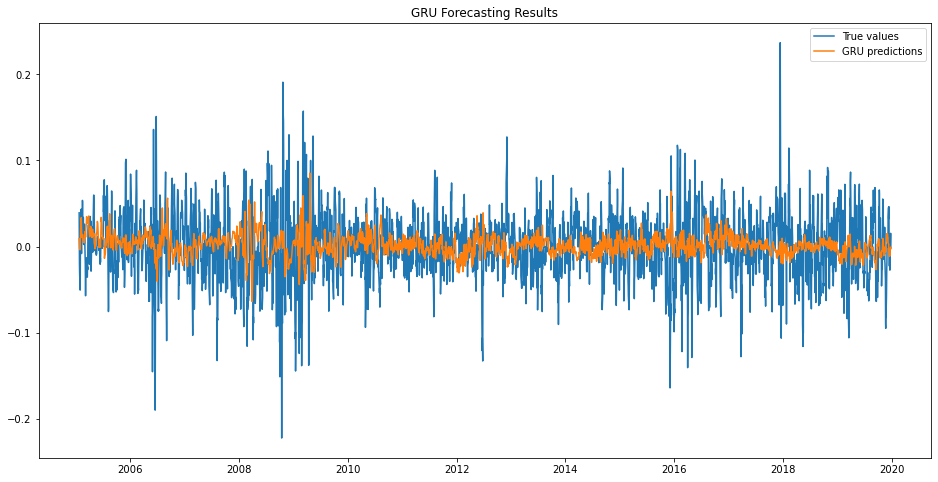

In [14]:
plt.figure(figsize=(16,8))
plt.plot(testGraph['Target'], label='True values')
plt.plot(testGraph['GRU'], label = 'GRU predictions')
plt.title("GRU Forecasting Results")
plt.legend()
plt.show()

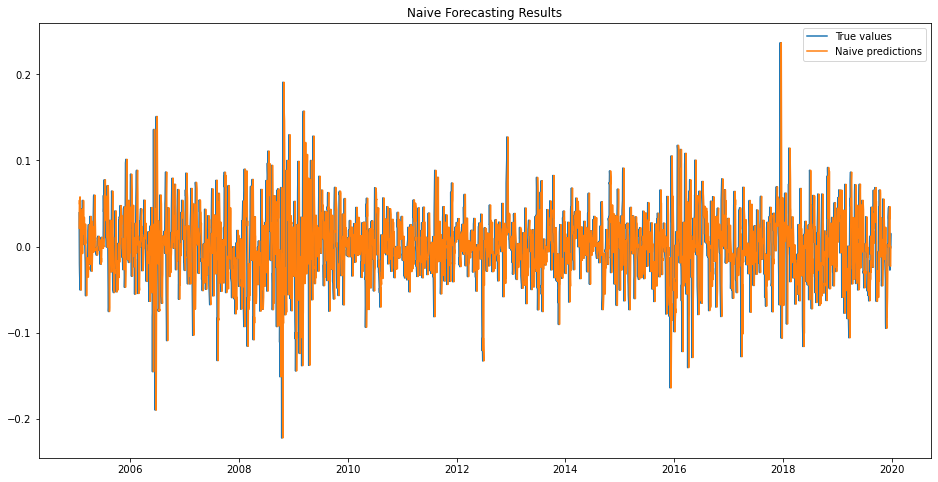

In [15]:
plt.figure(figsize=(16,8))
plt.plot(testGraph['Target'], label='True values')
plt.plot(testGraph['Naive'], label = 'Naive predictions')
plt.title("Naive Forecasting Results")
plt.legend()
plt.show()

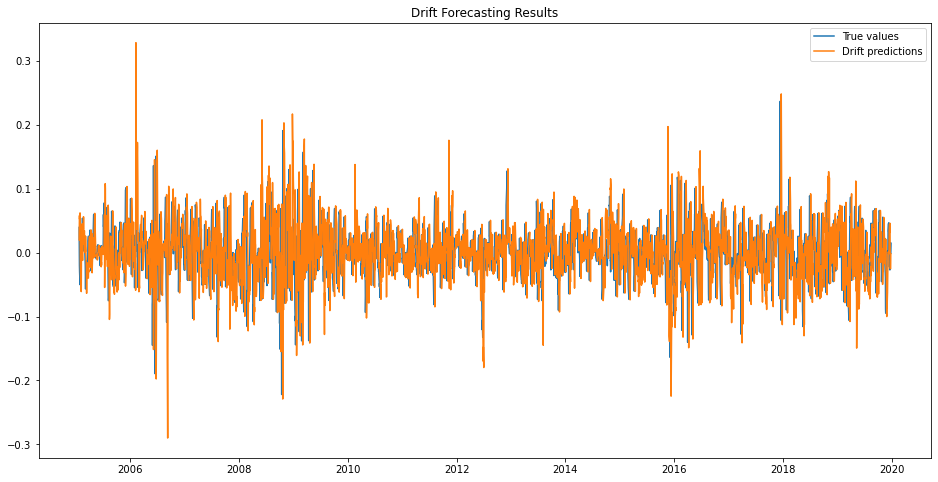

In [16]:
plt.figure(figsize=(16,8))
plt.plot(testGraph['Target'], label='True values')
plt.plot(testGraph['Drift'], label = 'Drift predictions')
plt.title("Drift Forecasting Results")
plt.legend()
plt.show()

**Save the predictions to a csv file**

In [17]:
savePredictions = pd.DataFrame(df[-numpreds:]['Target'])

savePredictions['ABG LSTM'] = lstm_predictions[-numpreds:]
savePredictions['ABG GRU'] = gru_predictions[-numpreds:]
savePredictions['ABG Naive'] = naive_predictions[-numpreds:]
savePredictions['ABG Drift'] = drift_predictions[-numpreds:]
savePredictions.drop(['Target'], axis=1, inplace=True)

savePredictions.to_csv(r'./ABG_Predictions.csv', index=True, header=True)

In [18]:
savePredictions.head()

ABG LSTM   ABG GRU  ABG Naive  ABG Drift
Date                                                
2005-01-25  0.023323  0.009225   0.021521   0.019930
2005-01-26  0.026548  0.006254   0.043485   0.045736
2005-01-27  0.029705  0.001780   0.053928   0.057845
2005-01-28  0.032856 -0.001555   0.049250   0.052285
2005-01-31  0.036458 -0.003650   0.057798   0.062074